# Plot correlation between loop and mC/ATAC/RNA

In [1]:
import cooler
import numpy as np
import pandas as pd
from scipy.sparse import triu
from scipy.stats import pearsonr, zscore, norm
from multiprocessing import Pool
from concurrent.futures import ProcessPoolExecutor, as_completed
from ALLCools.mcds import MCDS
from ALLCools.mcds.utilities import calculate_posterior_mc_frac
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm as cm
import seaborn as sns

mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'


In [2]:
leg = ['L23_IT', 'L4_IT', 'L5_IT', 'L6_IT', 'L6_IT_Car3', 'L56_NP', 'L6_CT', 'L6b', 'L5_ET', 'Amy', 
       'Lamp5', 'Lamp5_LHX6', 'Sncg', 'Vip', 'Pvalb', 'Pvalb_ChC', 'Sst', 'CHD7', 
       'MSN_D1', 'MSN_D2', 'Foxp2', 'SubCtx', 
       'ASC', 'ODC', 'OPC', 'MGC', 'PC', 'EC', 'VLMC'
      ]
legname = ['L2/3-IT', 'L4-IT', 'L5-IT', 'L6-IT', 'L6-IT-Car3', 'L5/6-NP', 'L6-CT', 'L6b', 'L5-ET', 'Amy-Exc', 
       'Lamp5', 'Lamp5-Lhx6', 'Sncg', 'Vip', 'Pvalb', 'Pvalb-ChC', 'Sst', 'Chd7', 
       'MSN-D1', 'MSN-D2', 'Foxp2', 'SubCtx-Cplx', 
       'ASC', 'ODC', 'OPC', 'MGC', 'PC', 'EC', 'VLMC'
      ]
leg2name = {xx:yy for xx,yy in zip(leg, legname)}


In [3]:
leg = {'exc': ['L23_IT', 'L4_IT', 'L5_IT', 'L6_IT', 'L6_IT_Car3', 'L56_NP', 'L6_CT', 'L6b', 'Amy'], 
       'inh': ['Lamp5', 'Lamp5_LHX6', 'Sncg', 'Vip', 'Pvalb', 'Pvalb_ChC', 'Sst', 'CHD7'], 
       'msn': ['MSN_D1', 'MSN_D2', 'Foxp2'], 
       'sub': ['SubCtx'], 
       'glia': ['ASC', 'ODC', 'OPC'], 
       'mgc': ['MGC'], 
       'smc': ['PC'], 
       'endo': ['EC'], 
       'fibro': ['VLMC'],
      }
leg['neu'] = leg['exc'] + leg['inh'] + leg['msn'] + leg['sub']
leg['all'] = leg['neu'] + leg['glia'] + leg['mgc'] + leg['smc'] + leg['endo'] + leg['fibro']


In [4]:
group_name = 'neu'

In [5]:
leg = pd.Index(leg[group_name])
legname = leg.map(leg2name)
res = 10000

In [6]:
indir = '/home/jzhou_salk_edu/sky_workdir/hba/loop_majortype/'
outdir = f'/home/jzhou_salk_edu/sky_workdir/hba/loop_majortype/diff/{group_name}/'

In [8]:
loopall = pd.read_hdf(f'{outdir}merged_loop.hdf', key='data')
loopall

0         1         2      3         4         5    Qanova  \
0         chr1    900000    910000   chr1    960000    970000  3.750881   
1         chr1    900000    910000   chr1    970000    980000  3.322128   
2         chr1    910000    920000   chr1    970000    980000  3.293559   
3         chr1    910000    920000   chr1    980000    990000  2.704021   
4         chr1    910000    920000   chr1    990000   1000000  2.819877   
...        ...       ...       ...    ...       ...       ...       ...   
2873610  chr22  50570000  50580000  chr22  50670000  50680000  1.646674   
2873611  chr22  50580000  50590000  chr22  50670000  50680000  2.256175   
2873612  chr22  50590000  50600000  chr22  50670000  50680000  3.531459   
2873613  chr22  50600000  50610000  chr22  50670000  50680000  4.896728   
2873614  chr22  50610000  50620000  chr22  50670000  50680000  5.475712   

            Eanova    Tanova  mCG_corr  mCH_corr  ATAC_corr  
0         6.097476  2.068213  0.031954  0.094070   0.253426  
1         6.001146  2.007495 -0.090257  0.070470   0.265731  
2         5.439024  2.229271 -0.018746 -0.044665   0.376666  
3         5.648575  2.289167 -0.105304 -0.060823   0.306052  
4         5.675182  1.669268 -0.354732 -0.320624   0.051738  
...            ...       ...       ...       ...        ...  
2873610  11.822375  1.625390  0.009941 -0.277535   0.078601  
2873611  11.555016  1.335000 -0.049832 -0.312835   0.082439  
2873612  11.165133  1.195543  0.075519 -0.135215   0.085896  
2873613  11.926161  2.028210  0.152859 -0.214300   0.119297  
2873614  13.031472  3.153314 -0.041111 -0.198155   0.250070  

[2873615 rows x 12 columns]

In [9]:
loopq = pd.read_hdf(f'{outdir}loop_Q.hdf', key='data')
loopt = pd.read_hdf(f'{outdir}loop_T.hdf', key='data')


In [10]:
loopcg = pd.read_hdf(f'{outdir}loop_mCG.hdf', key='data')
loopch = pd.read_hdf(f'{outdir}loop_mCH.hdf', key='data')
loopatac = pd.read_hdf(f'{outdir}loop_ATAC.hdf', key='data')


## Loop Corr with mC

In [11]:
thres1 = norm.isf(0.025)
thres2 = norm.isf(0.15)
print(thres1, thres2)


1.9599639845400545 1.0364333894937898


In [12]:
def t2z(x):
    return x * (groupT.max() - groupT.min()) / (len(groupT) - 1) + groupT.min()
def z2t(x):
    return (x - groupT.min()) * (len(groupT) - 1) / (groupT.max() - groupT.min())
def q2z(x):
    return x * (groupQ.max() - groupQ.min()) / (len(groupQ) - 1) + groupQ.min()
def z2q(x):
    return (x - groupQ.min()) * (len(groupQ) - 1) / (groupQ.max() - groupQ.min())
    

In [13]:
loopall['Tgroup'], groupT = pd.cut(np.clip(zscore(loopall['Tanova']), -1, 10), 100, labels=False, retbins=True)
loopall['Qgroup'], groupQ = pd.cut(np.clip(zscore(loopall['Qanova']), -1, 10), 100, labels=False, retbins=True)


In [14]:
xx1 = [x for x in range(int(np.around(z2q(thres1))), 100)]
yy1 = [z2t(thres1**2 / q2z(x)) for x in xx1]
yy2 = [x for x in range(int(np.around(z2t(thres1))), 100)][::-1]
xx2 = [z2q(thres1**2 / t2z(x)) for x in yy2]
xx = xx2 + xx1
yy = yy2 + yy1
t1 = z2t(thres1)
t2 = z2q(thres1)
t3 = z2t(thres2)
t4 = z2q(thres2)


In [15]:
tmp = loopall.groupby(['Tgroup','Qgroup'])['mCG_corr'].mean()
groupcgcorr = np.zeros((100, 100)) / 0
groupcgcorr[(tmp.index.get_level_values('Tgroup'), tmp.index.get_level_values('Qgroup'))] = tmp.values


In [16]:
tmp = loopall.groupby(['Tgroup','Qgroup'])['mCH_corr'].mean()
groupchcorr = np.zeros((100, 100)) / 0
groupchcorr[(tmp.index.get_level_values('Tgroup'), tmp.index.get_level_values('Qgroup'))] = tmp.values


In [17]:
tmp = loopall.groupby(['Tgroup','Qgroup'])['ATAC_corr'].mean()
groupataccorr = np.zeros((100, 100)) / 0
groupataccorr[(tmp.index.get_level_values('Tgroup'), tmp.index.get_level_values('Qgroup'))] = tmp.values


In [18]:
tmp = loopall.groupby(['Tgroup','Qgroup'])['mCG_corr'].count()
groupcount = np.zeros((100, 100))
groupcount[(tmp.index.get_level_values('Tgroup'), tmp.index.get_level_values('Qgroup'))] = tmp.values + 1


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


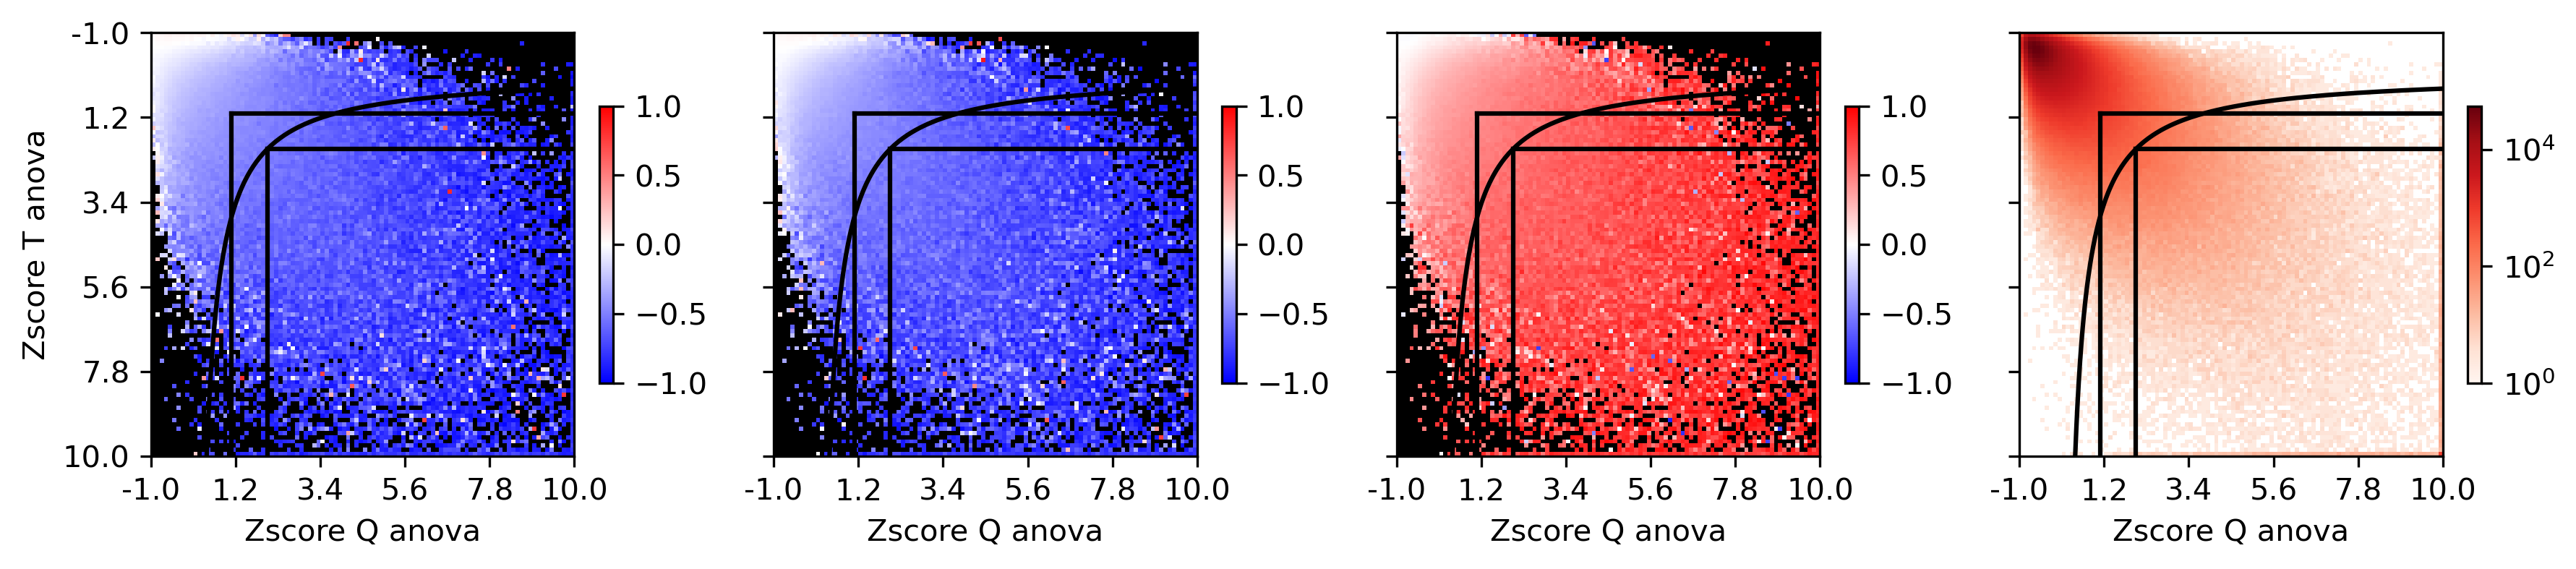

In [19]:
cmap = mpl.cm.bwr
cmap.set_bad('black', 1.0)

fig, axes = plt.subplots(1, 4, figsize=(12,3), sharex='all', sharey='all', dpi=300)
ax = axes[0]
plot = ax.imshow(groupcgcorr, vmin=-1, vmax=1, cmap=cmap)
ax.plot([t2, t2], [t1, 99], color='k')
ax.plot([t2, 99], [t1, t1], color='k')
ax.plot(xx, yy, color='k')
ax.plot([t4, t4], [t3, 99], color='k')
ax.plot([t4, 99], [t3, t3], color='k')

fig.colorbar(plot, ax=ax, shrink=0.5, fraction=0.1)
ax.set_xlabel('Zscore Q anova')
ax.set_ylabel('Zscore T anova')

ax = axes[1]
plot = ax.imshow(groupchcorr, vmin=-1, vmax=1, cmap=cmap)
ax.plot([t2, t2], [t1, 99], color='k')
ax.plot([t2, 99], [t1, t1], color='k')
ax.plot(xx, yy, color='k')
ax.plot([t4, t4], [t3, 99], color='k')
ax.plot([t4, 99], [t3, t3], color='k')

fig.colorbar(plot, ax=ax, shrink=0.5, fraction=0.1)
ax.set_xlabel('Zscore Q anova')

ax = axes[2]
plot = ax.imshow(groupataccorr, vmin=-1, vmax=1, cmap=cmap)
ax.plot([t2, t2], [t1, 99], color='k')
ax.plot([t2, 99], [t1, t1], color='k')
ax.plot(xx, yy, color='k')
ax.plot([t4, t4], [t3, 99], color='k')
ax.plot([t4, 99], [t3, t3], color='k')

fig.colorbar(plot, ax=ax, shrink=0.5, fraction=0.1)
ax.set_xlabel('Zscore Q anova')

ax = axes[3]
plot = ax.imshow(groupcount, cmap='Reds', norm=LogNorm(vmin=1))
fig.colorbar(plot, ax=ax, shrink=0.5, fraction=0.1)
ax.set_xticks(np.arange(-0.5, 100.5, 20))
ax.set_yticks(np.arange(-0.5, 100.5, 20))
ax.set_xticklabels(np.around(groupQ[np.arange(0,100.5,20).astype(int)], decimals=1))
ax.set_yticklabels(np.around(groupT[np.arange(0,100.5,20).astype(int)], decimals=1))
ax.plot([t2, t2], [t1, 99], color='k')
ax.plot([t2, 99], [t1, t1], color='k')
ax.plot(xx, yy, color='k')
ax.plot([t4, t4], [t3, 99], color='k')
ax.plot([t4, 99], [t3, t3], color='k')

ax.set_xlabel('Zscore Q anova')
plt.tight_layout()
# plt.savefig(f'majortype_{group_name}_diffloop_QTcorr.pdf', transparent=True)


In [20]:
loopall['Tgroup'], groupT = pd.cut(zscore(np.log(loopall['Tanova'])), 100, labels=False, retbins=True)
loopall['Qgroup'], groupQ = pd.cut(zscore(np.log(loopall['Qanova'])), 100, labels=False, retbins=True)


In [21]:
xx1 = [x for x in range(int(np.around(z2q(thres1))), 100)]
yy1 = [z2t(thres1**2 / q2z(x)) for x in xx1]
yy2 = [x for x in range(int(np.around(z2t(thres1))), 100)][::-1]
xx2 = [z2q(thres1**2 / t2z(x)) for x in yy2]
xx = xx2 + xx1
yy = yy2 + yy1
t1 = z2t(thres1)
t2 = z2q(thres1)
t3 = z2t(thres2)
t4 = z2q(thres2)


In [22]:
tmp = loopall.groupby(['Tgroup','Qgroup'])['mCG_corr'].mean()
groupcgcorr = np.zeros((100, 100)) / 0
groupcgcorr[(tmp.index.get_level_values('Tgroup'), tmp.index.get_level_values('Qgroup'))] = tmp.values


In [23]:
tmp = loopall.groupby(['Tgroup','Qgroup'])['mCH_corr'].mean()
groupchcorr = np.zeros((100, 100)) / 0
groupchcorr[(tmp.index.get_level_values('Tgroup'), tmp.index.get_level_values('Qgroup'))] = tmp.values


In [24]:
tmp = loopall.groupby(['Tgroup','Qgroup'])['ATAC_corr'].mean()
groupataccorr = np.zeros((100, 100)) / 0
groupataccorr[(tmp.index.get_level_values('Tgroup'), tmp.index.get_level_values('Qgroup'))] = tmp.values


In [25]:
tmp = loopall.groupby(['Tgroup','Qgroup'])['mCG_corr'].count()
groupcount = np.zeros((100, 100))
groupcount[(tmp.index.get_level_values('Tgroup'), tmp.index.get_level_values('Qgroup'))] = tmp.values + 1


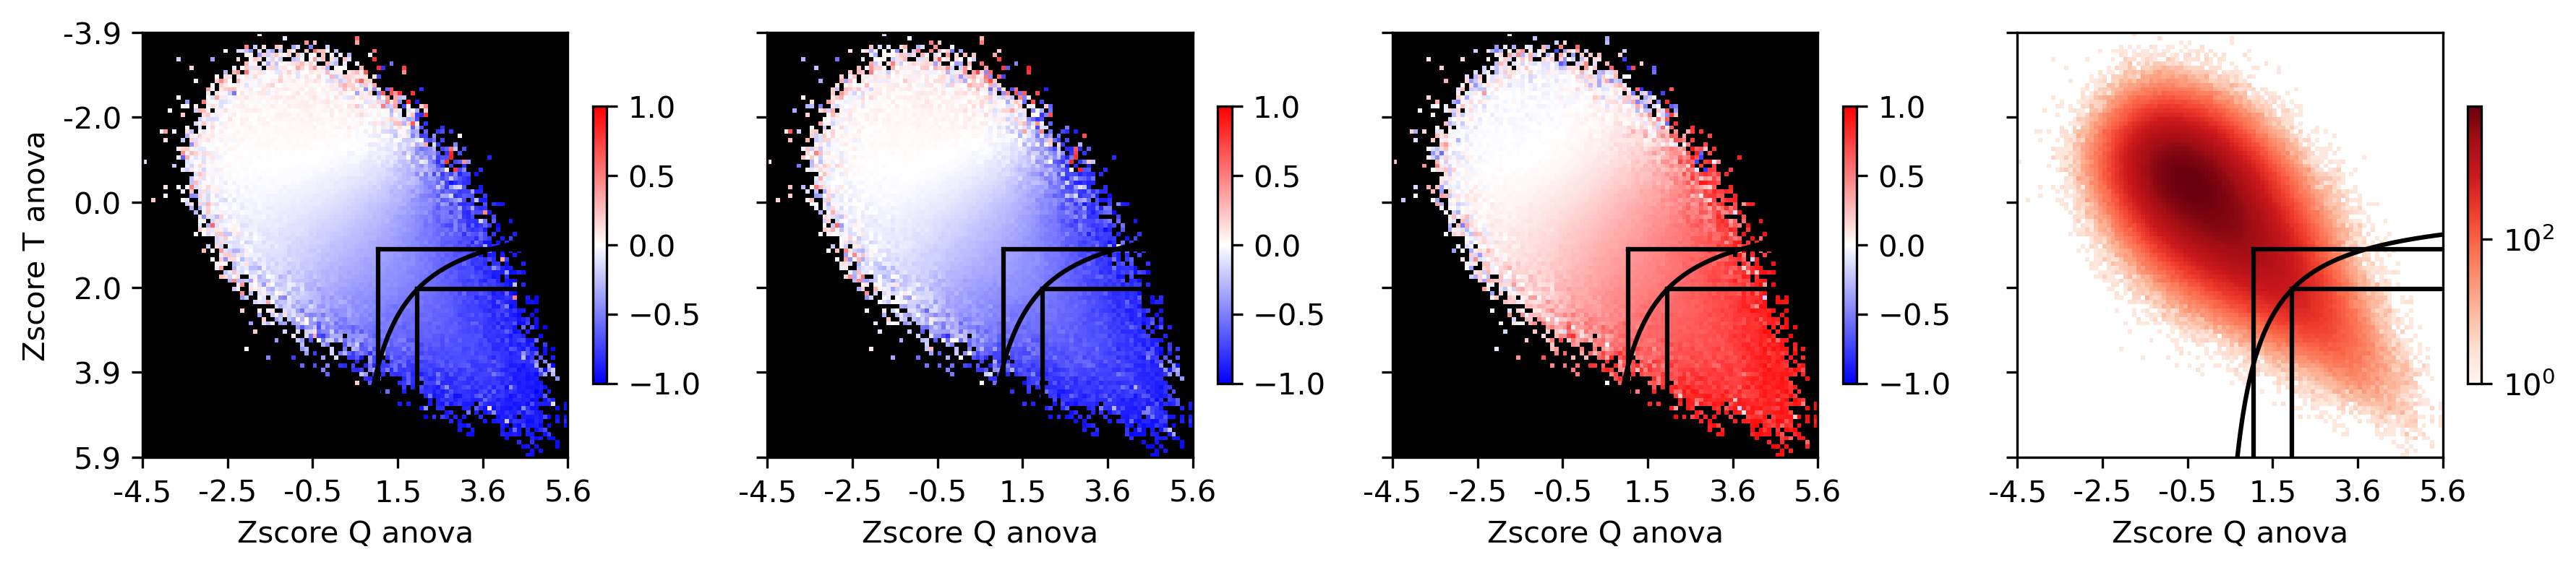

In [26]:
cmap = mpl.cm.bwr
cmap.set_bad('black', 1.0)

fig, axes = plt.subplots(1, 4, figsize=(12,3), sharex='all', sharey='all', dpi=300)
ax = axes[0]
plot = ax.imshow(groupcgcorr, vmin=-1, vmax=1, cmap=cmap)
ax.plot([t2, t2], [t1, 99], color='k')
ax.plot([t2, 99], [t1, t1], color='k')
ax.plot(xx, yy, color='k')
ax.plot([t4, t4], [t3, 99], color='k')
ax.plot([t4, 99], [t3, t3], color='k')

fig.colorbar(plot, ax=ax, shrink=0.5, fraction=0.1)
ax.set_xlabel('Zscore Q anova')
ax.set_ylabel('Zscore T anova')

ax = axes[1]
plot = ax.imshow(groupchcorr, vmin=-1, vmax=1, cmap=cmap)
ax.plot([t2, t2], [t1, 99], color='k')
ax.plot([t2, 99], [t1, t1], color='k')
ax.plot(xx, yy, color='k')
ax.plot([t4, t4], [t3, 99], color='k')
ax.plot([t4, 99], [t3, t3], color='k')

fig.colorbar(plot, ax=ax, shrink=0.5, fraction=0.1)
ax.set_xlabel('Zscore Q anova')

ax = axes[2]
plot = ax.imshow(groupataccorr, vmin=-1, vmax=1, cmap=cmap)
ax.plot([t2, t2], [t1, 99], color='k')
ax.plot([t2, 99], [t1, t1], color='k')
ax.plot(xx, yy, color='k')
ax.plot([t4, t4], [t3, 99], color='k')
ax.plot([t4, 99], [t3, t3], color='k')

fig.colorbar(plot, ax=ax, shrink=0.5, fraction=0.1)
ax.set_xlabel('Zscore Q anova')

ax = axes[3]
plot = ax.imshow(groupcount, cmap='Reds', norm=LogNorm(vmin=1))
fig.colorbar(plot, ax=ax, shrink=0.5, fraction=0.1)
ax.set_xticks(np.arange(-0.5, 100.5, 20))
ax.set_yticks(np.arange(-0.5, 100.5, 20))
ax.set_xticklabels(np.around(groupQ[np.arange(0,100.5,20).astype(int)], decimals=1))
ax.set_yticklabels(np.around(groupT[np.arange(0,100.5,20).astype(int)], decimals=1))
ax.plot([t2, t2], [t1, 99], color='k')
ax.plot([t2, 99], [t1, t1], color='k')
ax.plot(xx, yy, color='k')
ax.plot([t4, t4], [t3, 99], color='k')
ax.plot([t4, 99], [t3, t3], color='k')

ax.set_xlabel('Zscore Q anova')
plt.tight_layout()
# plt.savefig(f'majortype_{group_name}_diffloop_logQTcorr.pdf', transparent=True)


In [27]:
selb = ((zscore(loopall['Qanova'])>thres2) & (zscore(loopall['Tanova'])>thres2))
print(selb.sum())

148395


In [28]:
selc = ((zscore(loopall['Qanova'])<0) & (zscore(loopall['Tanova'])<0))
print(selc.sum())

1595845


In [29]:
loopall['Qave_group'] = pd.cut(zscore(loopq.mean(axis=1)), 100, labels=False)
loopall['Tave_group'] = pd.cut(zscore(loopt.mean(axis=1)), 100, labels=False)


In [30]:
loopall['group'] = np.zeros(loopall.shape[0])
loopall.loc[selb, 'group'] = 1
loopall.loc[selc, 'group'] = -1

In [31]:
sel = [[], []]
for _,tmp in loopall.loc[loopall['group']!=0].groupby(['Qave_group','Tave_group']):
    t = tmp['group'].value_counts()
    if (len(t)==2) and t.min()>0:
        t = t.min()
        for i,(_,xx) in enumerate(tmp.groupby('group')):
            np.random.seed(0)
            if xx.shape[0]>t:
                sel[i].append(np.random.choice(xx.index, t, False))
            else:
                sel[i].append(xx.index)
    

In [32]:
selpos = np.concatenate(sel[0])
selneg = np.concatenate(sel[1])
print(selpos.shape[0], selneg.shape[0])


141180 141180


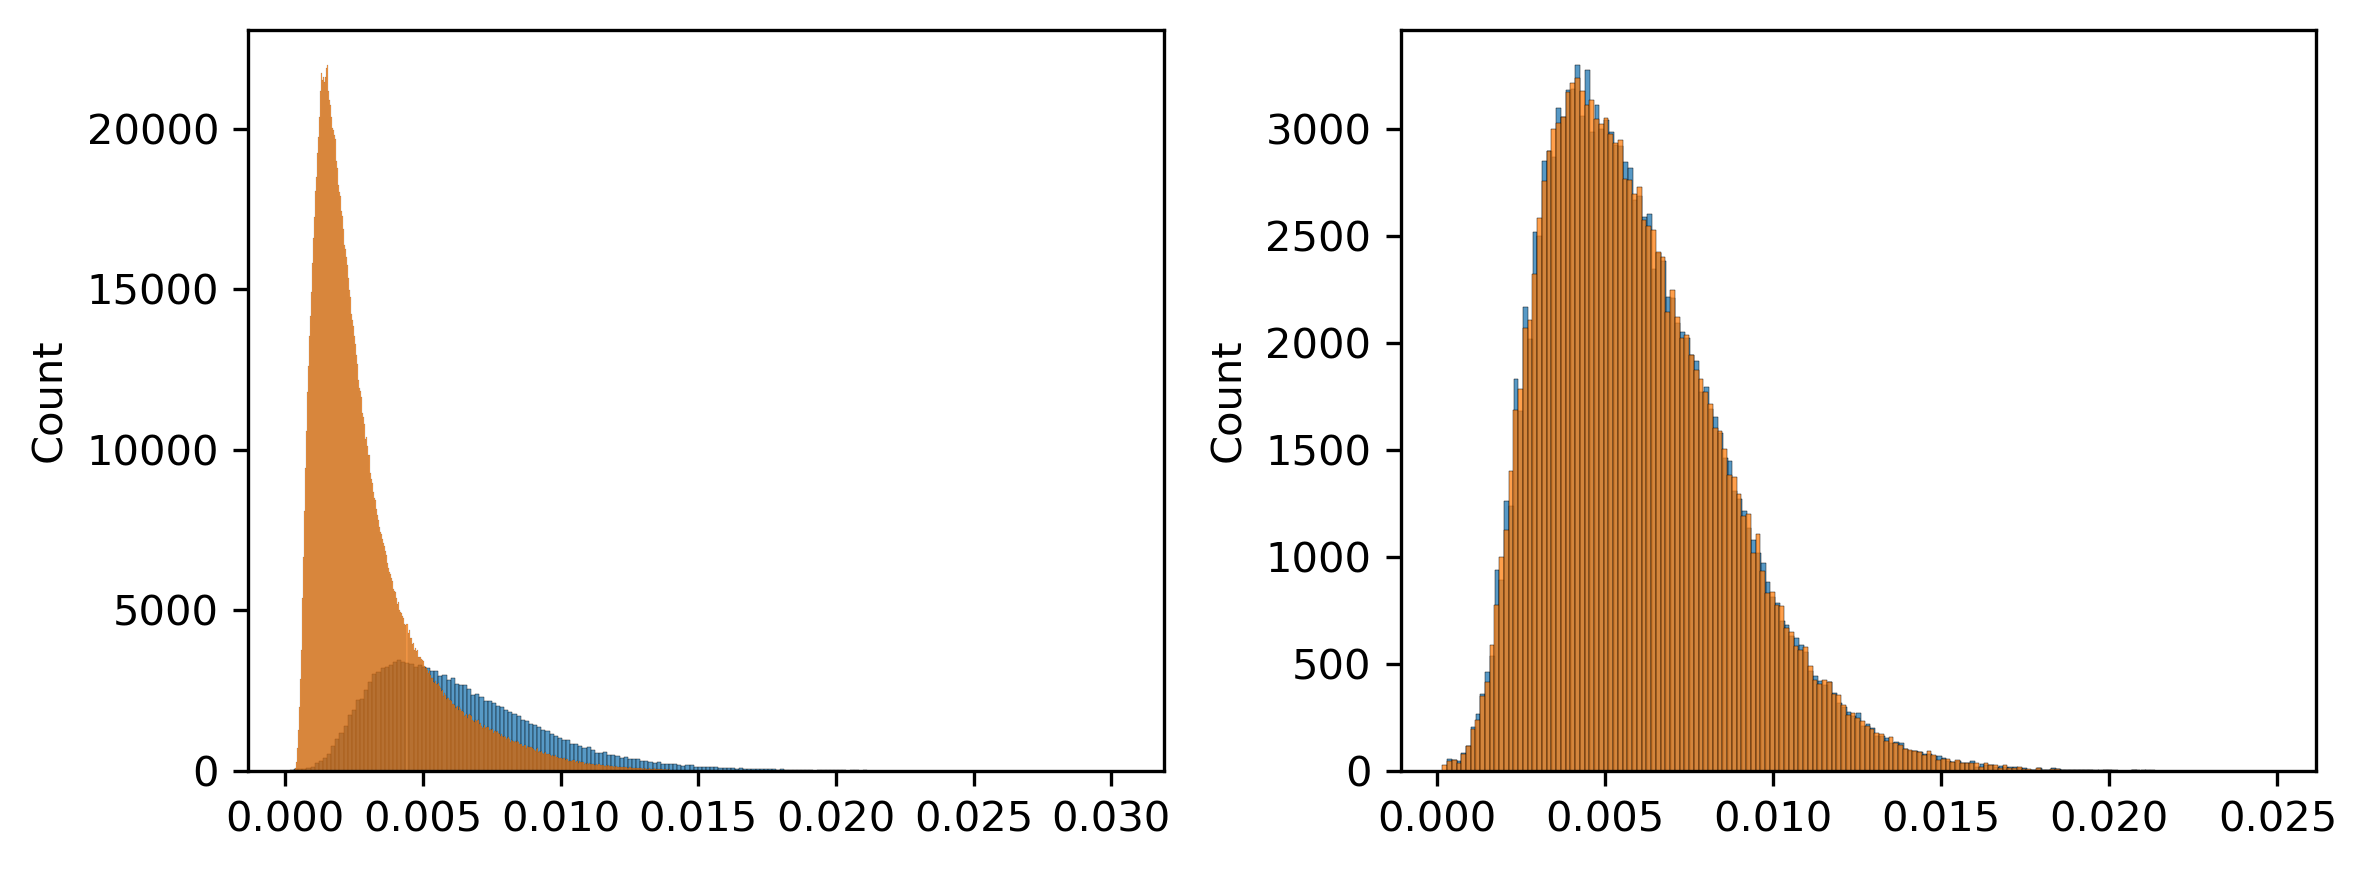

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(8,3), dpi=300)

ax = axes[0]
sns.histplot(loopq.loc[selb].mean(axis=1), ax=ax)
sns.histplot(loopq.loc[selc].mean(axis=1), ax=ax)

ax = axes[1]
sns.histplot(loopq.loc[selpos].mean(axis=1), ax=ax)
sns.histplot(loopq.loc[selneg].mean(axis=1), ax=ax)

plt.tight_layout()

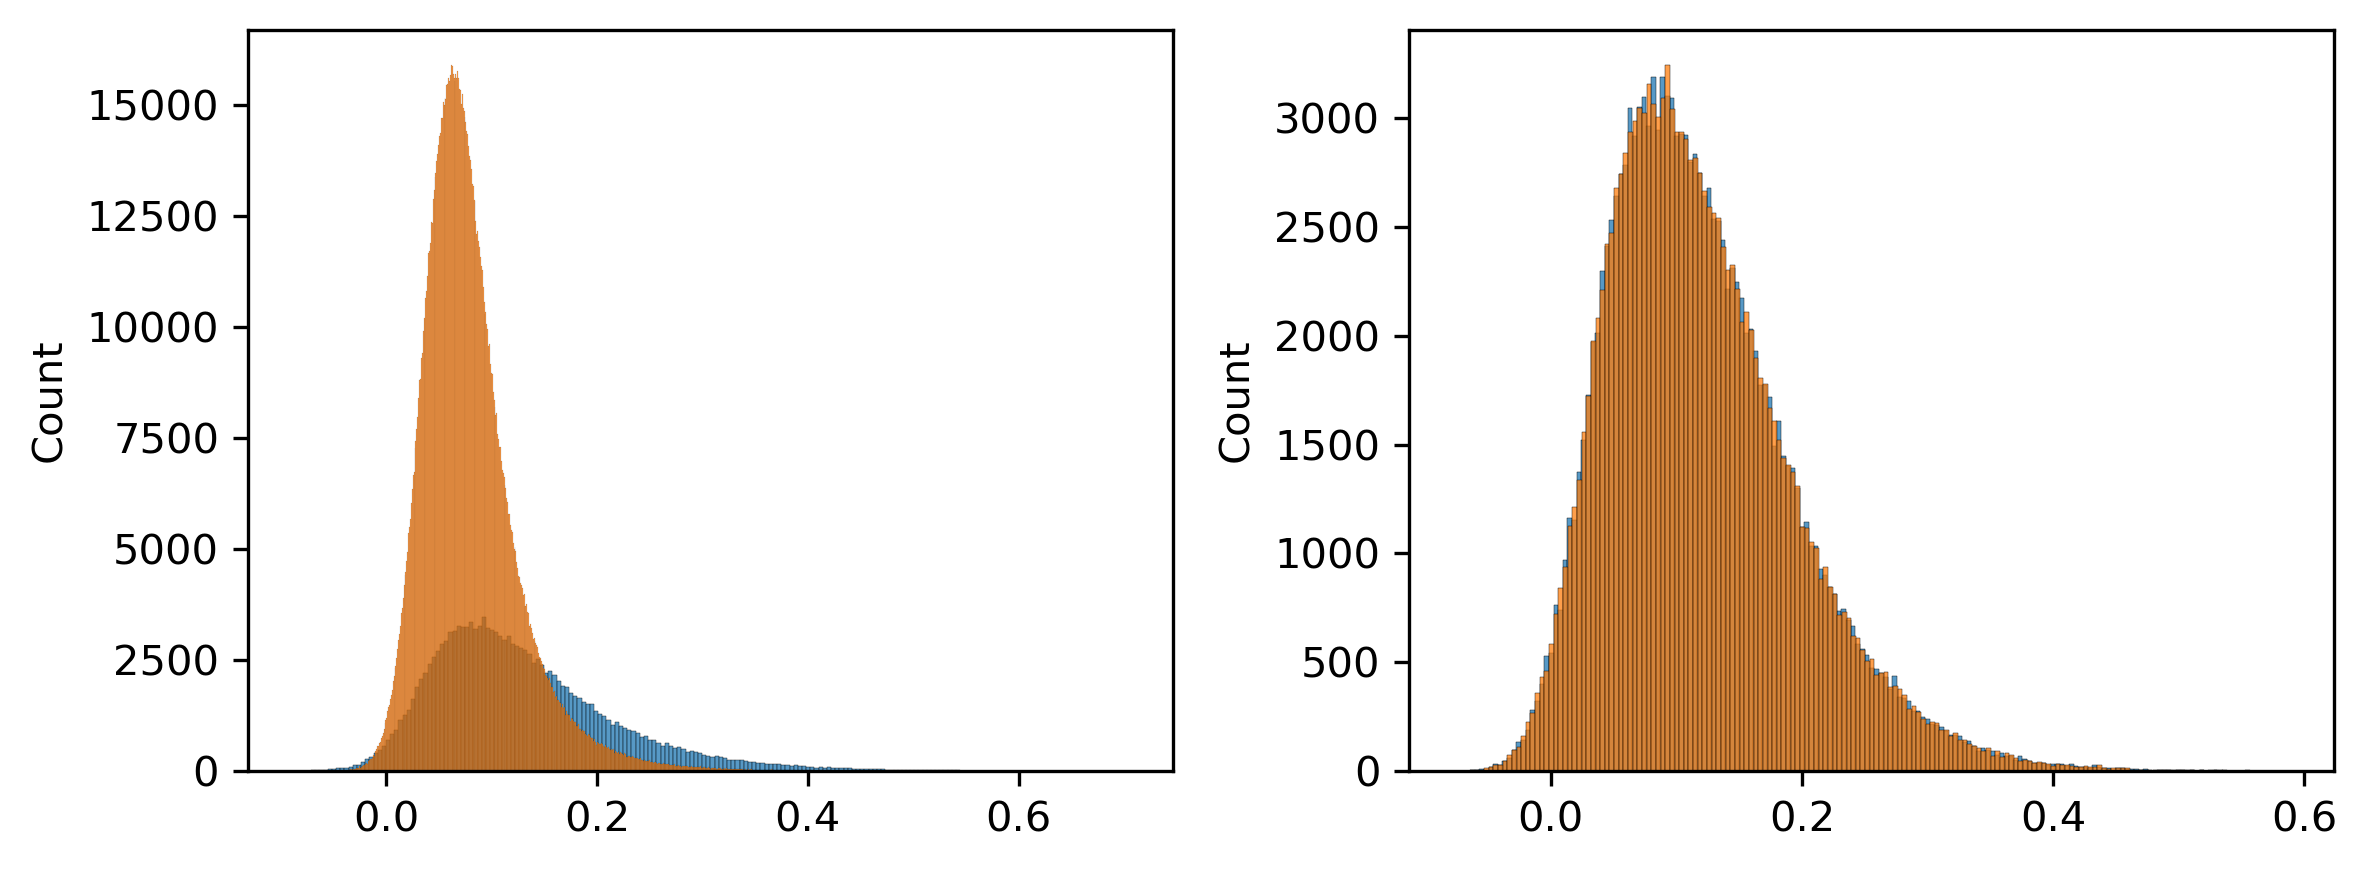

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(8,3), dpi=300)

ax = axes[0]
sns.histplot(loopt.loc[selb].mean(axis=1), ax=ax)
sns.histplot(loopt.loc[selc].mean(axis=1), ax=ax)

ax = axes[1]
sns.histplot(loopt.loc[selpos].mean(axis=1), ax=ax)
sns.histplot(loopt.loc[selneg].mean(axis=1), ax=ax)

plt.tight_layout()

In [35]:
loopall.loc[np.sort(selpos), [0,1,2,3,4,5]].to_csv(f'{outdir}{group_name}_diffloop.bedpe', header=False, index=False, sep='\t')
loopall.loc[np.sort(selneg), [0,1,2,3,4,5]].to_csv(f'{outdir}{group_name}_consloop.bedpe', header=False, index=False, sep='\t')


In [36]:
tmpcg = loopcg.loc[selb].values
tmpcg = zscore(tmpcg, axis=1)


In [37]:
tmpch = loopch.loc[selb].values
tmpch = zscore(tmpch, axis=1)


In [38]:
tmpatac = loopatac.loc[selb].values
tmpatac = zscore(tmpatac, axis=1)


In [39]:
tmp3c = loopq.loc[selb].values
tmp3c = zscore(tmp3c, axis=1)


In [40]:
diffloop = loopall.loc[selb, [0,1,4]]
diffloop[[1, 4]] = diffloop[[1, 4]] // res
diffloop = diffloop.reset_index()
diffloop

index      0     1     4
0           111   chr1   102   127
1           112   chr1   102   128
2           113   chr1   102   129
3           114   chr1   102   130
4           137   chr1   103   127
...         ...    ...   ...   ...
148390  2873428  chr22  5025  5061
148391  2873429  chr22  5025  5062
148392  2873452  chr22  5026  5060
148393  2873453  chr22  5026  5061
148394  2873454  chr22  5026  5062

[148395 rows x 4 columns]

In [42]:
np.random.seed(0)
sel = np.random.choice(np.arange(len(tmp3c)), 2000, False)


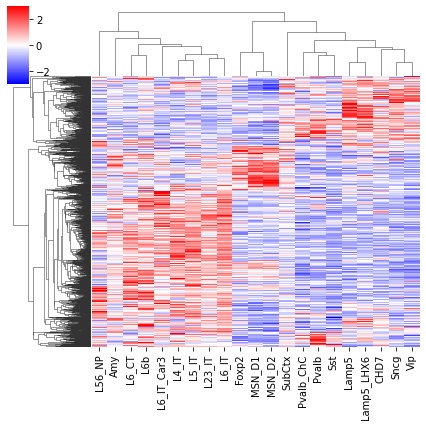

In [43]:
cg = sns.clustermap(tmp3c[sel], cmap='bwr', vmin=-3, vmax=3, metric='cosine', xticklabels=leg, yticklabels=[], figsize=(6,6))


In [44]:
rorder = cg.dendrogram_row.reordered_ind.copy()
corder = cg.dendrogram_col.reordered_ind.copy()

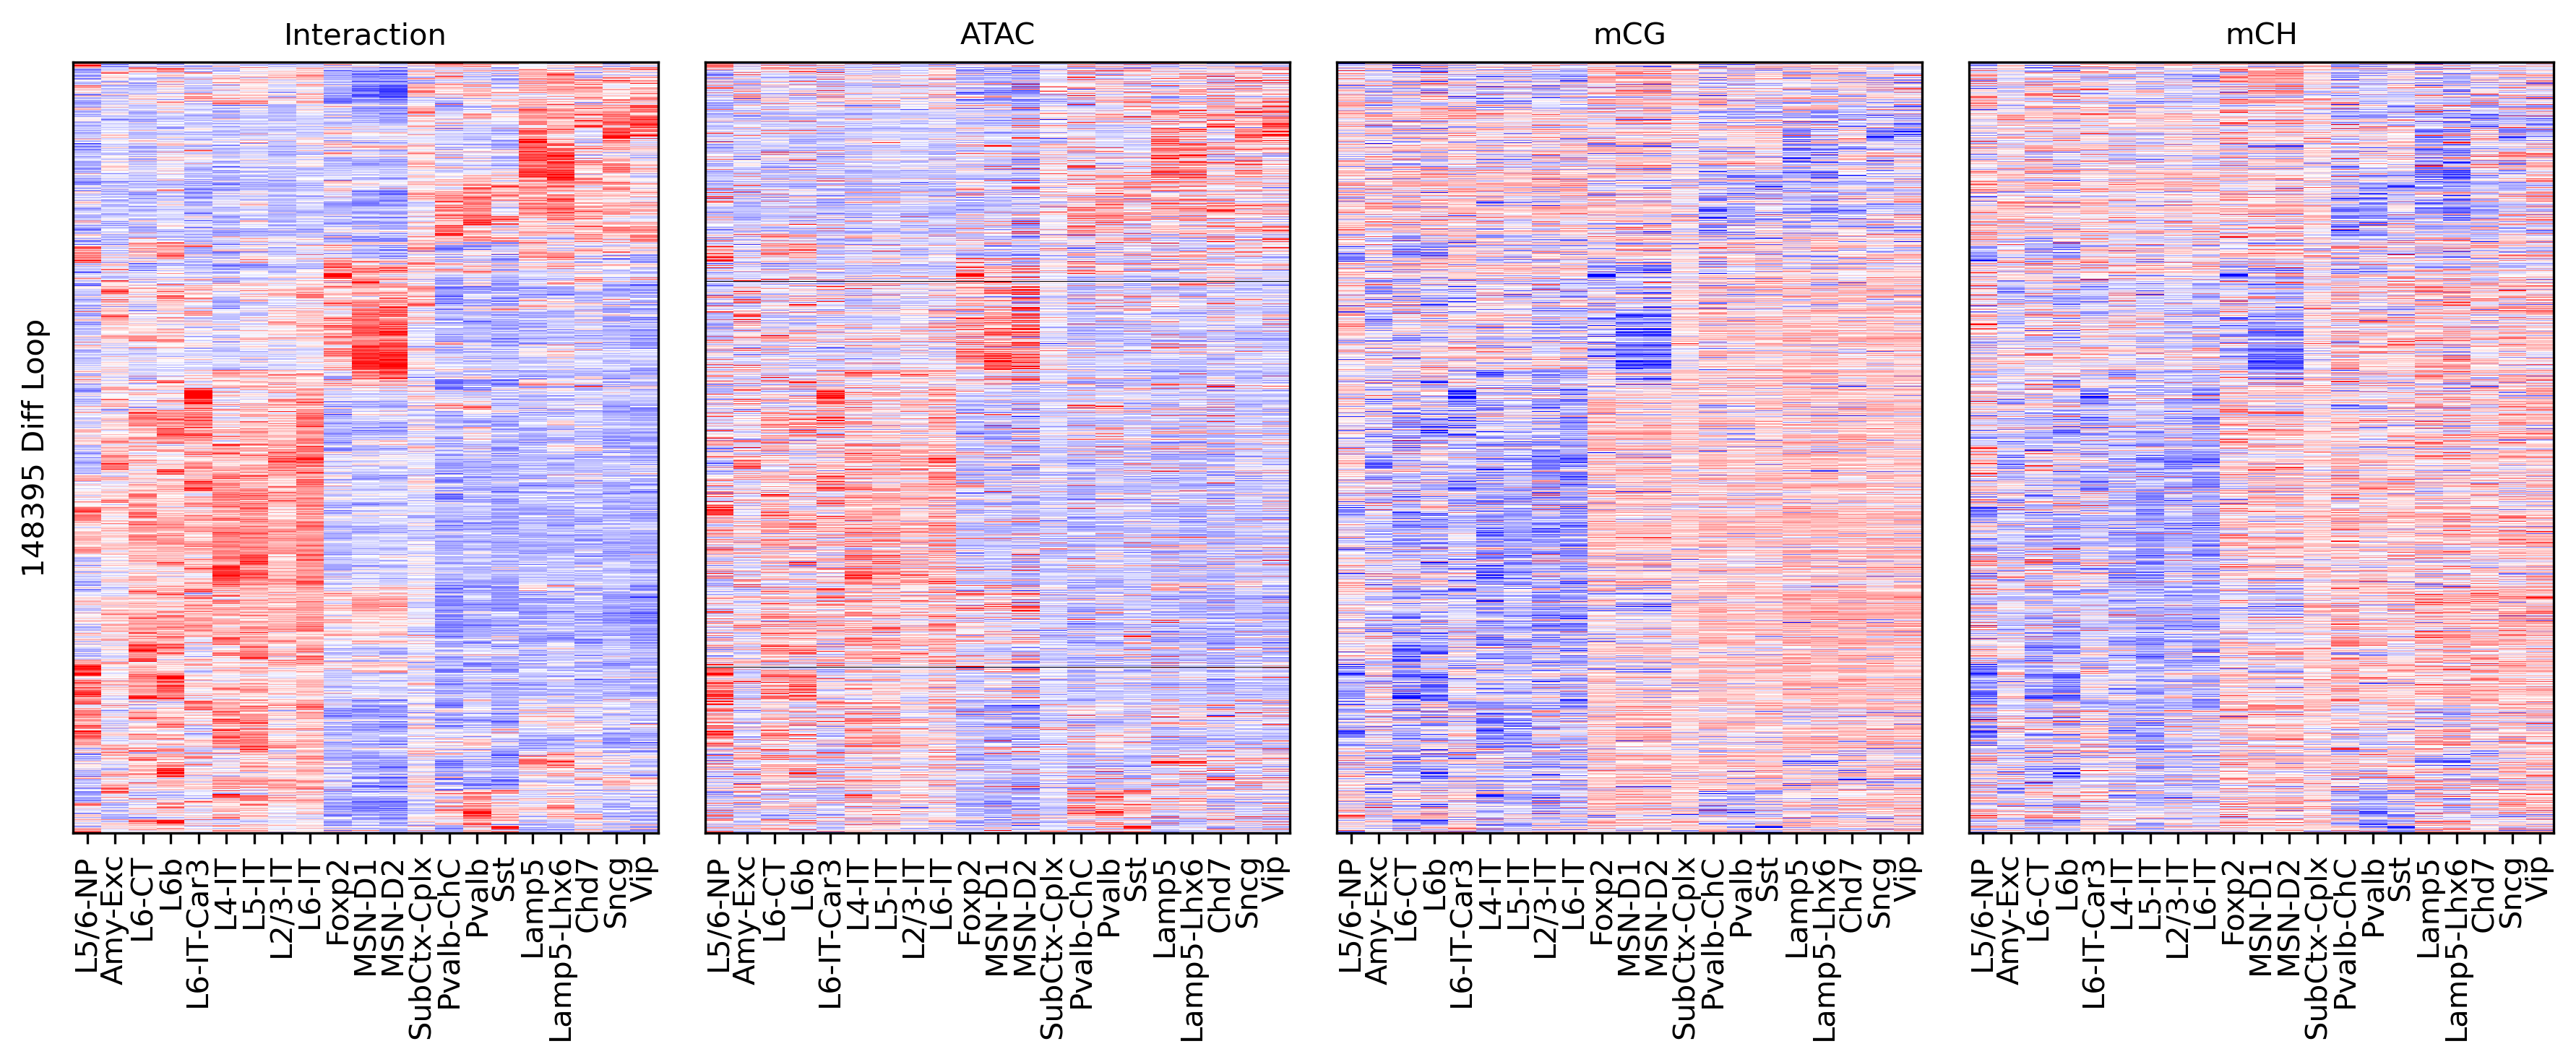

In [45]:
fig, axes = plt.subplots(1, 4, sharey='all', figsize=(12,5), dpi=300)

ax = axes[0]
ax.imshow(tmp3c[np.ix_(sel[rorder], corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('Interaction', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)
ax.set_yticks([])
ax.set_ylabel(f'{tmp3c.shape[0]} Diff Loop')

ax = axes[1]
ax.imshow(tmpatac[np.ix_(sel[rorder], corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('ATAC', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)

ax = axes[2]
ax.imshow(tmpcg[np.ix_(sel[rorder], corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('mCG', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)

ax = axes[3]
ax.imshow(tmpch[np.ix_(sel[rorder], corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('mCH', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)

plt.tight_layout()
# plt.savefig(f'majortype_{group_name}_diffloop_3C_mC.pdf', transparent=True)


Text(0, 0.5, 'PCC with Interaction')

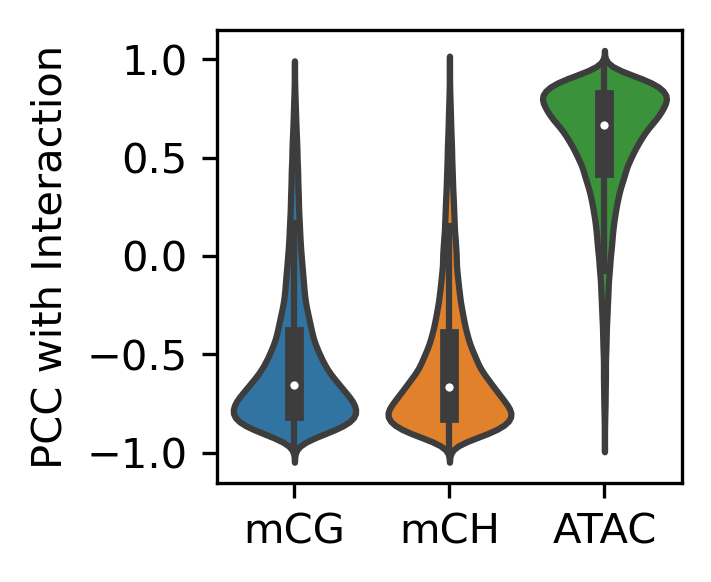

In [46]:
fig, ax = plt.subplots(figsize=(2,2), dpi=300)
sns.violinplot([loopall.loc[diffloop['index'], 'mCH_corr'], 
                loopall.loc[diffloop['index'], 'mCG_corr'], 
                loopall.loc[diffloop['index'], 'ATAC_corr']], ax=ax)
ax.set_xticklabels(['mCG', 'mCH', 'ATAC'])
ax.set_ylabel('PCC with Interaction')
# plt.savefig(f'majortype_{group_name}_diffloop_epicorr.pdf', transparent=True)


In [47]:
print(loopall.loc[diffloop['index'], 'mCH_corr'].median(),
      loopall.loc[diffloop['index'], 'mCG_corr'].median(),
      loopall.loc[diffloop['index'], 'ATAC_corr'].median(),
      diffloop.shape[0]
     )


-0.6547802960315396 -0.6665834836133143 0.6682089803377004 148395


In [48]:
loopall.reset_index().loc[selb, [0,2,4,'index']].to_csv(f'{outdir}diff_interloop.bed', sep='\t', index=False, header=False)


In [ ]:
!bedtools intersect -wa -wb -a ~/sky_workdir/hba/ref/gencode.v33.gene.slop2k.bed -b diff_interloop.bed -f 1 | gzip > gene_in_diffloop.txt.gz


In [49]:
corr_all = []

## Differential Loop vs All Gene within Loop

In [50]:
expr = pd.read_hdf('/home/jzhou_salk_edu/sky_workdir/hba/rna_majortype/cluster_expr.hdf')
stats = pd.read_hdf(f'/home/jzhou_salk_edu/sky_workdir/hba/rna_majortype/{group_name}_deg_stats.hdf')
genefilter = (stats['stats']>0)
expr = expr.loc[:, genefilter]
stats = stats.loc[genefilter]


In [54]:
data = pd.read_csv(f'{outdir}gene_in_diffloop.txt', usecols=(3,9), sep='\t', header=None, index_col=None)
data.columns = ['gene_id', 'loop_id']
data = data.loc[data['gene_id'].isin(expr.columns)]
print(data.shape[0])


168938


In [55]:
tmp3c = loopq.loc[data['loop_id'].values].values
tmp3c = zscore(tmp3c, axis=1)


In [56]:
tmprna = expr.loc[leg, data['gene_id']].T.values
# stdev = tmprna.std(axis=1)
tmprna = zscore(tmprna, axis=1)


In [57]:
np.random.seed(0)
sel = np.random.choice(np.arange(len(tmp3c)), 2000, False)


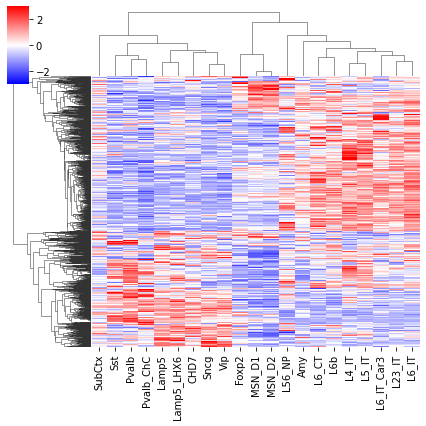

In [58]:
cg = sns.clustermap(tmp3c[sel], cmap='bwr', vmin=-3, vmax=3, metric='cosine', xticklabels=leg, yticklabels=[], figsize=(6,6))


In [59]:
rorder = cg.dendrogram_row.reordered_ind.copy()
corder = cg.dendrogram_col.reordered_ind.copy()

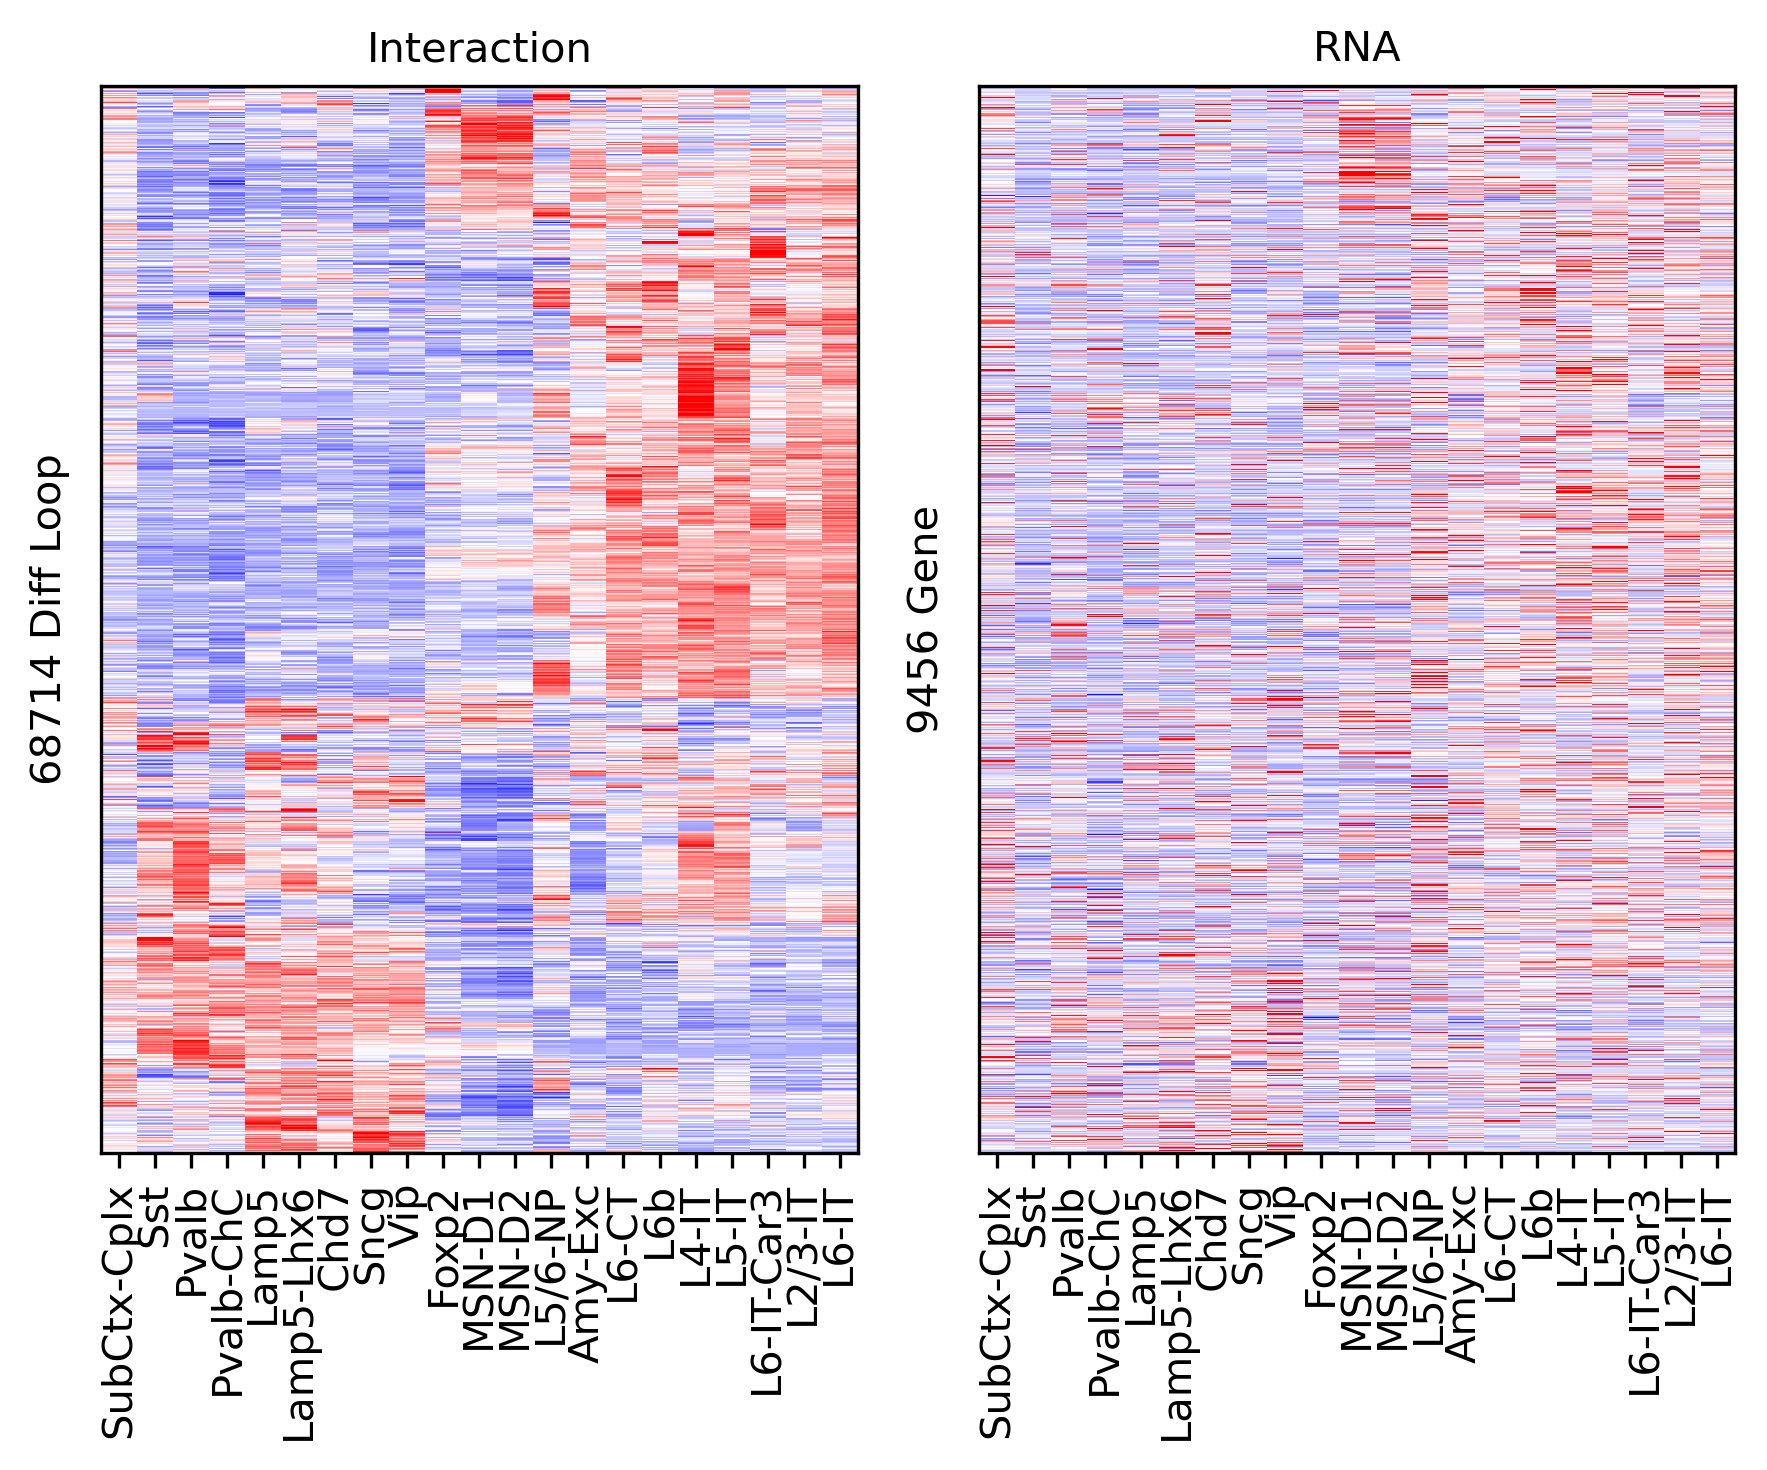

In [60]:
fig, axes = plt.subplots(1, 2, sharey='all', figsize=(6,5), dpi=300)

ax = axes[0]
ax.imshow(tmp3c[np.ix_(sel[rorder], corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('Interaction', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)
ax.set_yticks([])
ax.set_ylabel(f'{np.unique(data["loop_id"]).shape[0]} Diff Loop')

ax = axes[1]
ax.imshow(tmprna[np.ix_(sel[rorder], corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('RNA', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)
ax.set_ylabel(f'{np.unique(data["gene_id"]).shape[0]} Gene')

plt.tight_layout()
# plt.savefig(f'majortype_{group_name}_diffloop_3C_RNA_allwithin.pdf', transparent=True)


In [61]:
corr = np.array([pearsonr(xx, yy)[0] for xx,yy in zip(tmp3c, tmprna)])
corr_all.append(corr)

## Differential Loop vs DEG within Loop

In [62]:
from scipy.stats import rankdata

deg = np.zeros(genefilter.shape[0])
for i in range(len(leg)-1):
    for j in range(i+1, len(leg)):
        tmp = np.load(f'/home/jzhou_salk_edu/sky_workdir/hba/rna_majortype/DEG/{leg[i]}-{leg[j]}.npz')
        # deg[np.logical_and(np.abs(tmp['fc'])>1, tmp['fdr']<1e-3)] = 1
        rank = rankdata(tmp['fdr'])
        deg[rank<=100] = 1

print(deg.sum())

1131.0


In [63]:
selp = data['gene_id'].isin(genefilter.index[deg==1])
data = data.loc[selp]

In [64]:
tmp3c = tmp3c[selp]
tmprna = tmprna[selp]

In [65]:
np.random.seed(0)
sel = np.random.choice(np.arange(len(tmp3c)), 2000, False)


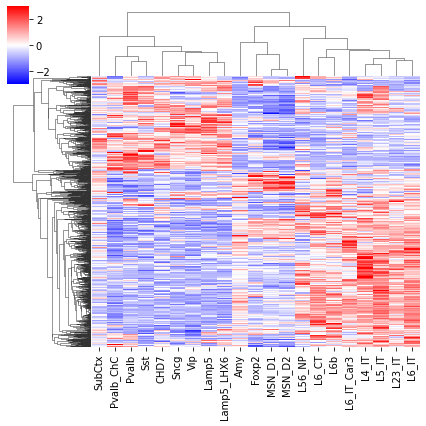

In [66]:
cg = sns.clustermap(tmp3c[sel], cmap='bwr', vmin=-3, vmax=3, metric='cosine', xticklabels=leg, yticklabels=[], figsize=(6,6))


In [67]:
rorder = cg.dendrogram_row.reordered_ind.copy()
corder = cg.dendrogram_col.reordered_ind.copy()

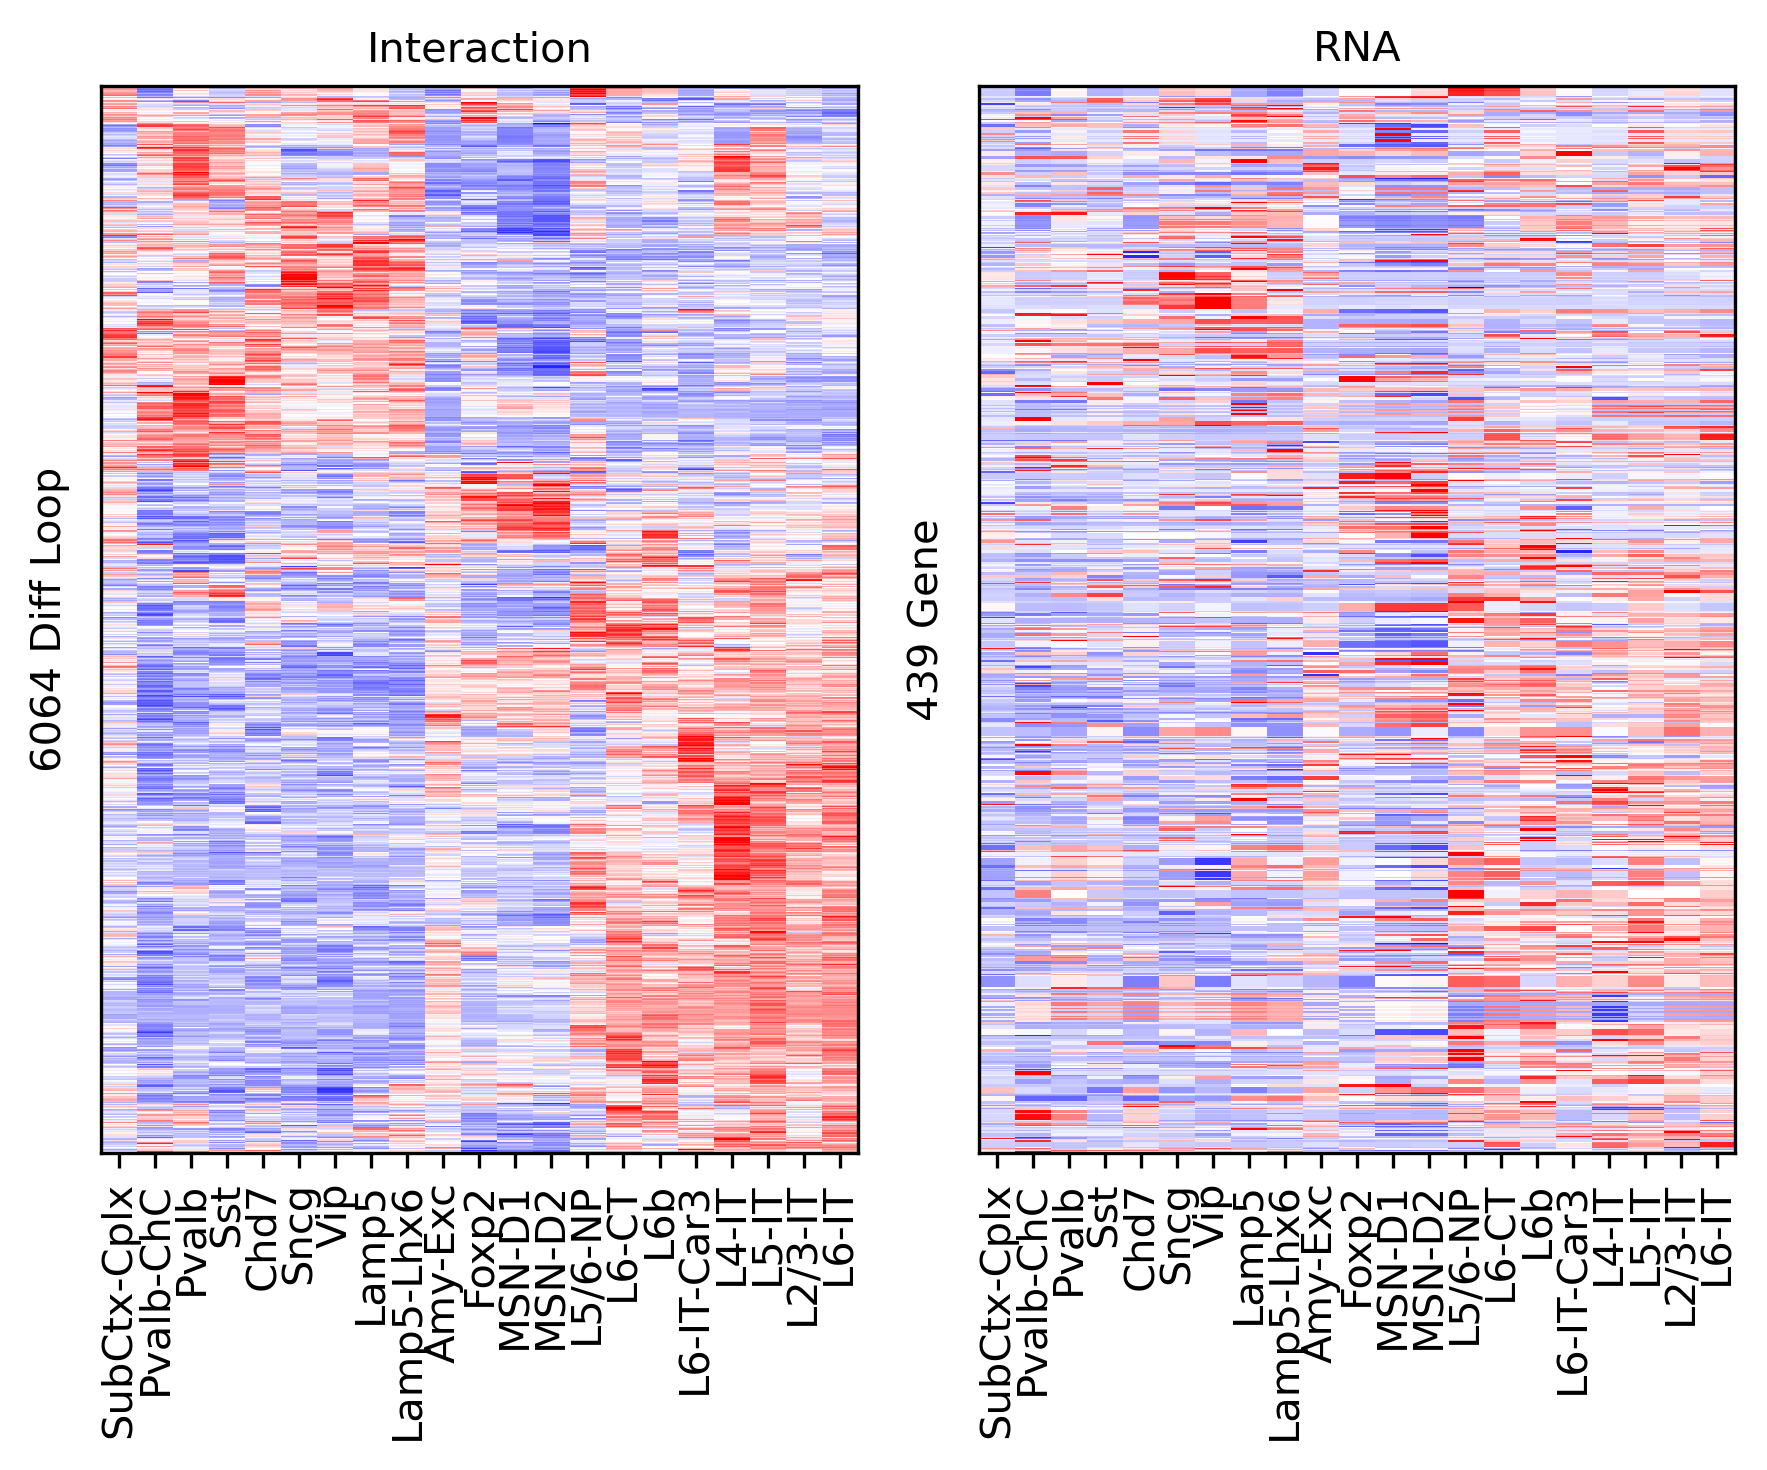

In [68]:
fig, axes = plt.subplots(1, 2, sharey='all', figsize=(6,5), dpi=300)

ax = axes[0]
ax.imshow(tmp3c[np.ix_(sel[rorder], corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('Interaction', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)
ax.set_yticks([])
ax.set_ylabel(f'{np.unique(data["loop_id"]).shape[0]} Diff Loop')

ax = axes[1]
ax.imshow(tmprna[np.ix_(sel[rorder], corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('RNA', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)
ax.set_ylabel(f'{np.unique(data["gene_id"]).shape[0]} Gene')

plt.tight_layout()
# plt.savefig(f'majortype_{group_name}_diffloop_3C_RNA_degwithin.pdf', transparent=True)


In [69]:
corr = np.array([pearsonr(xx, yy)[0] for xx,yy in zip(tmp3c, tmprna)])
corr_all.append(corr)


## Differential Loop vs All Gene TSS

In [70]:
data = pd.read_csv(f'/home/jzhou_salk_edu/sky_workdir/hba/ref/hg38.main.10kbin.TSS.slop2k.txt', sep='\t', header=None, index_col=None)
data[3] = data[0] + '-' + (data[1] // res).astype(str)
bin2gene = {xx:[] for xx in data[3].values}
data = data[data[6].isin(expr.columns)]
for xx,yy in data[[3,6]].values:
    bin2gene[xx].append(yy)


In [71]:
selloop = []
selgene = []
for loop in diffloop[[0, 1, 4, 'index']].values:
    xx = f'{loop[0]}-{loop[1]}'
    yy = f'{loop[0]}-{loop[2]}'
    zz = bin2gene[xx] + bin2gene[yy]
    if len(zz)>0:
        selloop.append(np.repeat([loop[3]], len(zz)))
        selgene.append(zz)

selloop = np.concatenate(selloop)
selgene = np.concatenate(selgene)
print(len(selloop), len(selgene))


56027 56027


In [72]:
tmp3c = loopq.loc[selloop].values
tmp3c = zscore(tmp3c, axis=1)


In [73]:
tmprna = expr.loc[leg, selgene].T.values
# stdev = tmprna.std(axis=1)
tmprna = zscore(tmprna, axis=1)


In [74]:
np.random.seed(0)
sel = np.random.choice(np.arange(len(tmp3c)), 2000, False)


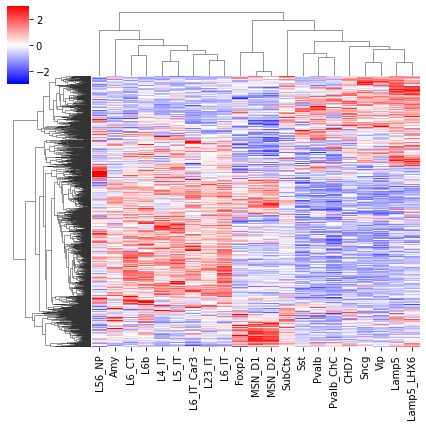

In [75]:
cg = sns.clustermap(tmp3c[sel], cmap='bwr', vmin=-3, vmax=3, metric='cosine', xticklabels=leg, yticklabels=[], figsize=(6,6))


In [76]:
rorder = cg.dendrogram_row.reordered_ind.copy()
corder = cg.dendrogram_col.reordered_ind.copy()

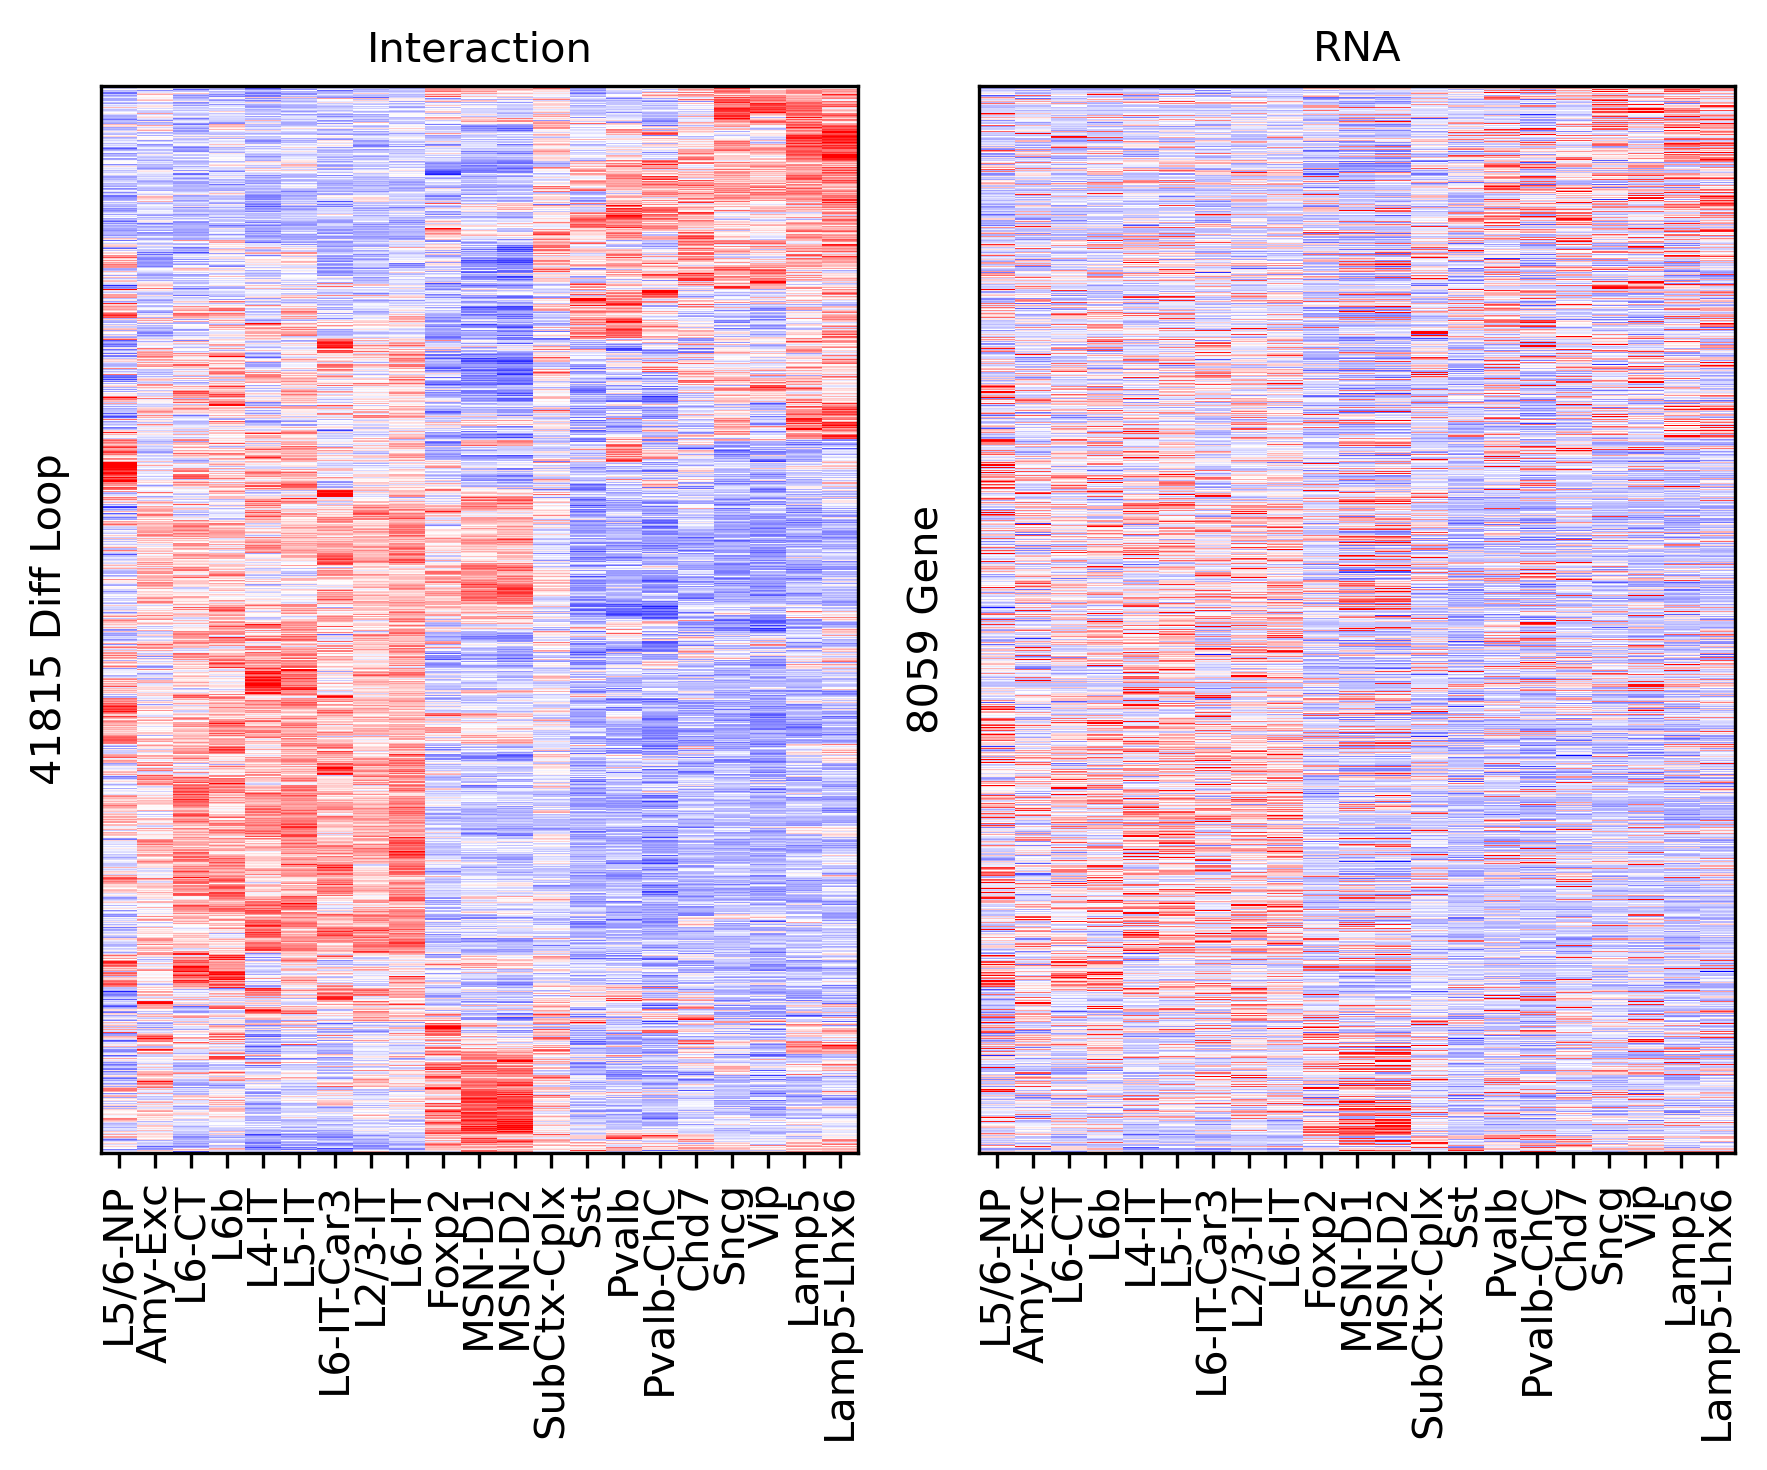

In [77]:
fig, axes = plt.subplots(1, 2, sharey='all', figsize=(6,5), dpi=300)

ax = axes[0]
ax.imshow(tmp3c[np.ix_(sel[rorder], corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('Interaction', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)
ax.set_yticks([])
ax.set_ylabel(f'{np.unique(selloop).shape[0]} Diff Loop')

ax = axes[1]
ax.imshow(tmprna[np.ix_(sel[rorder], corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('RNA', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)
ax.set_ylabel(f'{np.unique(selgene).shape[0]} Gene')

plt.tight_layout()
# plt.savefig(f'majortype_{group_name}_diffloop_3C_RNA_alltss.pdf', transparent=True)


In [78]:
corr = np.array([pearsonr(xx, yy)[0] for xx,yy in zip(tmp3c, tmprna)])
corr_all.append(corr)

## Differential Loop vs DEG TSS

In [79]:
selp = pd.Index(selgene).isin(genefilter.index[deg==1])

In [80]:
selgene = selgene[selp]
selloop = selloop[selp]

In [81]:
tmp3c = tmp3c[selp]
tmprna = tmprna[selp]

In [82]:
np.random.seed(0)
sel = np.random.choice(np.arange(len(tmp3c)), 2000, False)


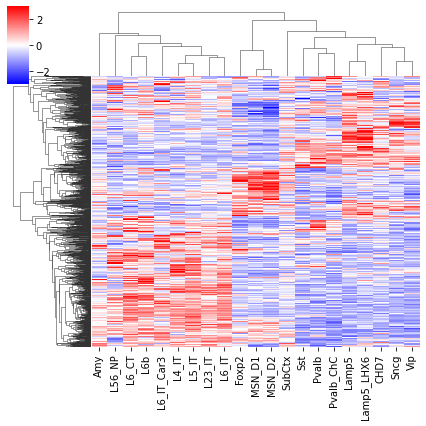

In [83]:
cg = sns.clustermap(tmp3c[sel], cmap='bwr', vmin=-3, vmax=3, metric='cosine', xticklabels=leg, yticklabels=[], figsize=(6,6))


In [84]:
rorder = cg.dendrogram_row.reordered_ind.copy()
corder = cg.dendrogram_col.reordered_ind.copy()

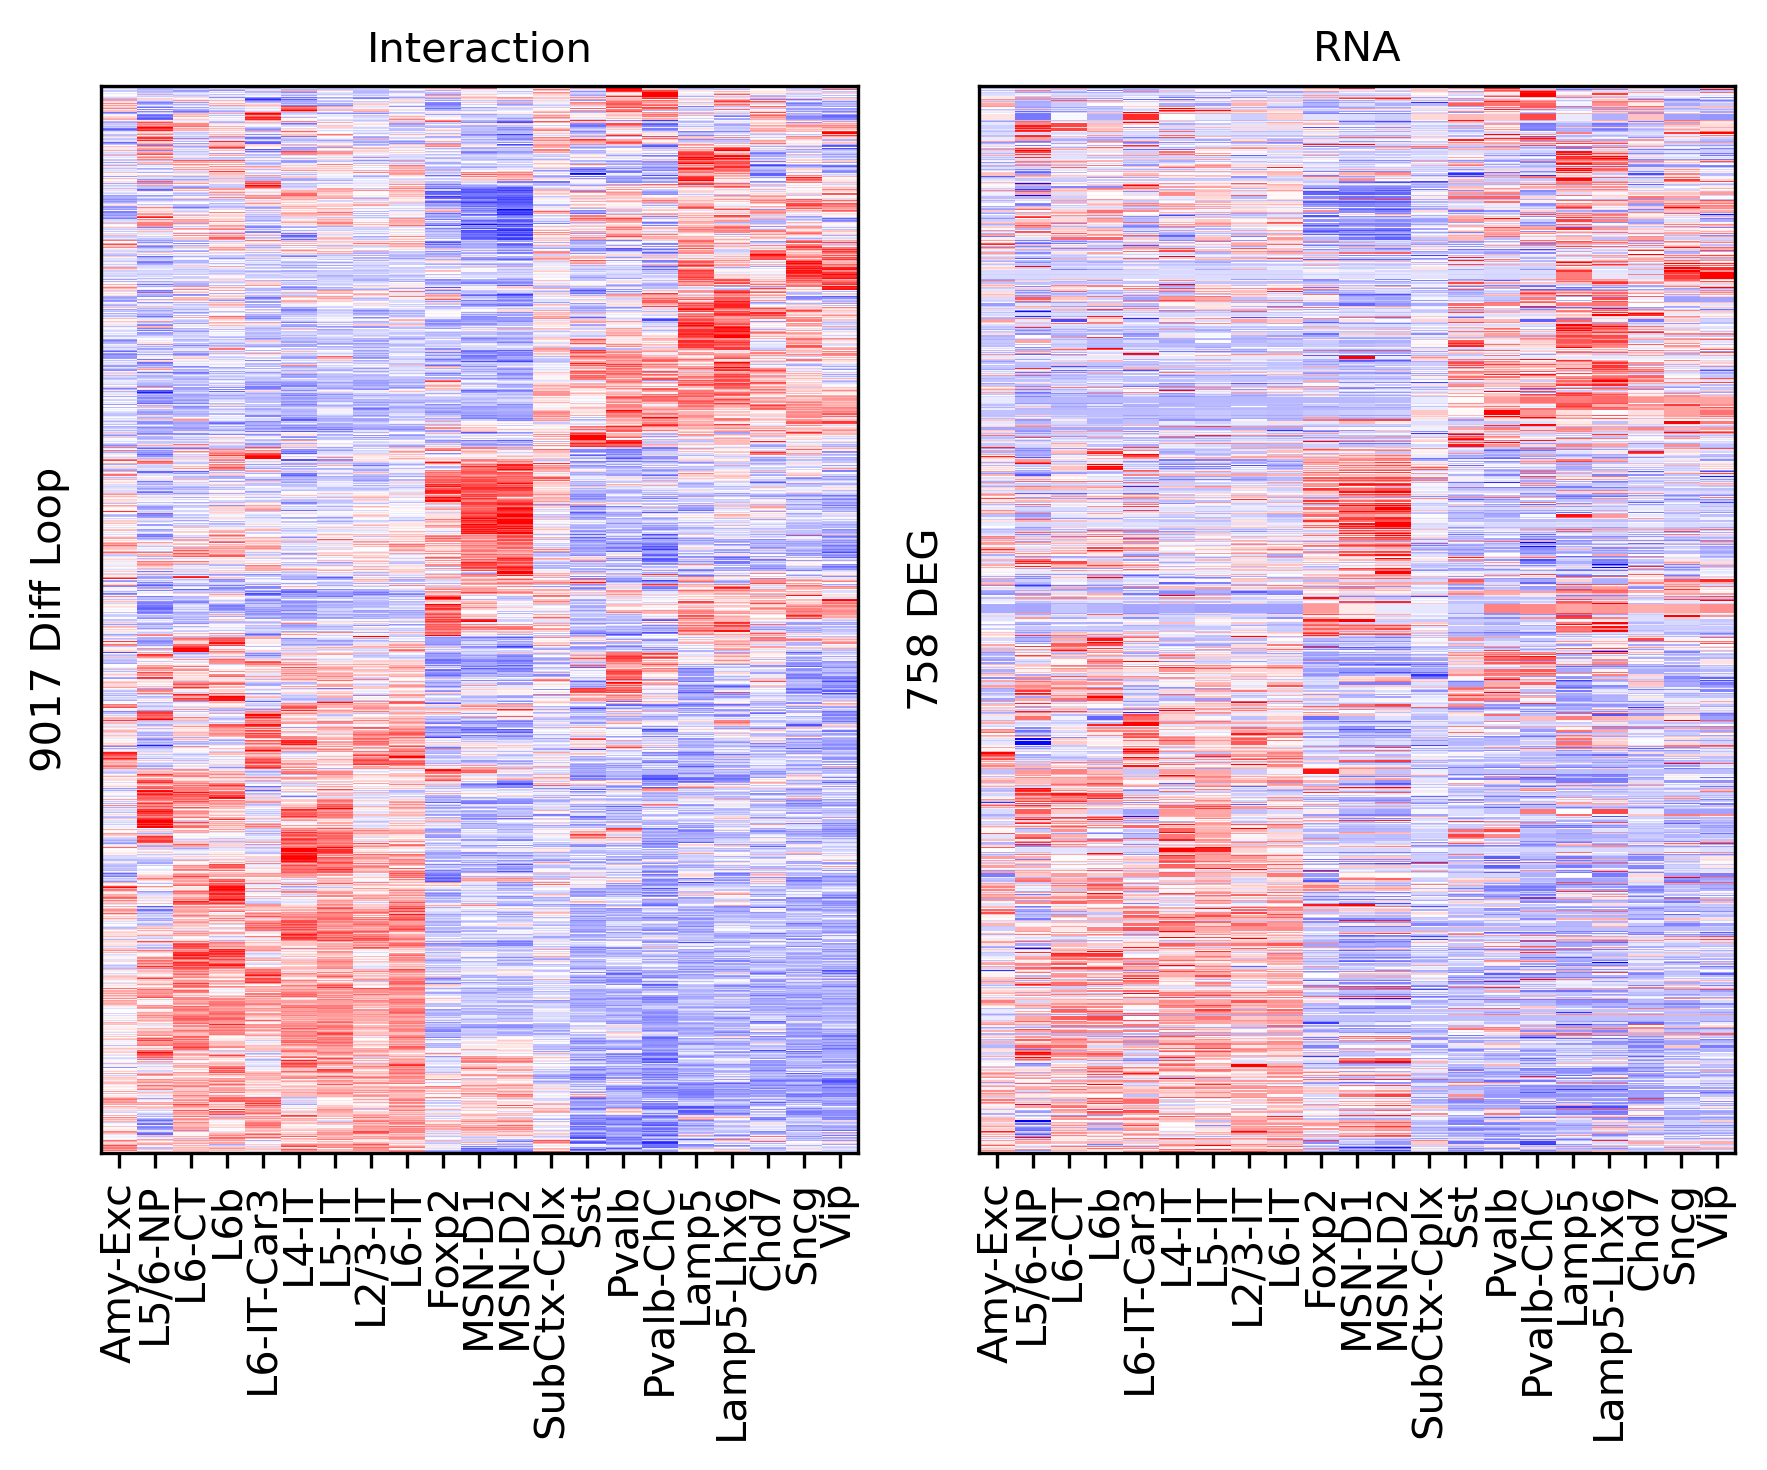

In [85]:
fig, axes = plt.subplots(1, 2, sharey='all', figsize=(6,5), dpi=300)

ax = axes[0]
ax.imshow(tmp3c[np.ix_(sel[rorder], corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('Interaction', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)
ax.set_yticks([])
ax.set_ylabel(f'{np.unique(selloop).shape[0]} Diff Loop')

ax = axes[1]
ax.imshow(tmprna[np.ix_(sel[rorder], corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('RNA', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)
ax.set_ylabel(f'{np.unique(selgene).shape[0]} DEG')

plt.tight_layout()
# plt.savefig(f'majortype_{group_name}_diffloop_3C_RNA_degtss.pdf', transparent=True)


In [86]:
corr = np.array([pearsonr(xx, yy)[0] for xx,yy in zip(tmp3c, tmprna)])
corr_all.append(corr)

## Differential Loop vs All Gene body

In [87]:
data = pd.read_csv(f'/home/jzhou_salk_edu/sky_workdir/hba/ref/hg38.main.10kbin.gene.slop2k.txt', sep='\t', header=None, index_col=None)
data[3] = data[0] + '-' + (data[1] // res).astype(str)
bin2gene = {xx:[] for xx in data[3].values}
data = data[data[6].isin(expr.columns)]
for xx,yy in data[[3,6]].values:
    bin2gene[xx].append(yy)


In [88]:
selloop = []
selgene = []
for loop in diffloop[[0, 1, 4, 'index']].values:
    xx = f'{loop[0]}-{loop[1]}'
    yy = f'{loop[0]}-{loop[2]}'
    zz = bin2gene[xx] + bin2gene[yy]
    if len(zz)>0:
        selloop.append(np.repeat([loop[3]], len(zz)))
        selgene.append(zz)

selloop = np.concatenate(selloop)
selgene = np.concatenate(selgene)
print(len(selloop), len(selgene))


247125 247125


In [89]:
tmp3c = loopq.loc[selloop].values
tmp3c = zscore(tmp3c, axis=1)


In [90]:
tmprna = expr.loc[leg, selgene].T.values
stdev = tmprna.std(axis=1)
tmprna = zscore(tmprna, axis=1)


In [91]:
np.random.seed(0)
sel = np.random.choice(np.arange(len(tmp3c)), 2000, False)


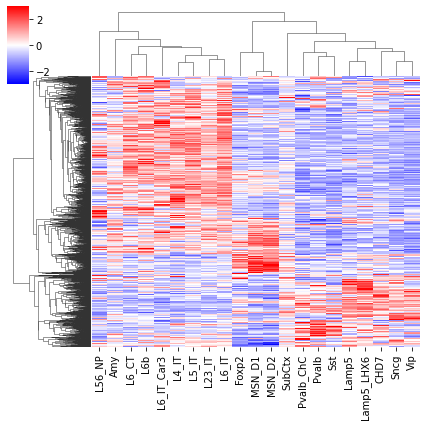

In [92]:
cg = sns.clustermap(tmp3c[sel], cmap='bwr', vmin=-3, vmax=3, metric='cosine', xticklabels=leg, yticklabels=[], figsize=(6,6))


In [93]:
rorder = cg.dendrogram_row.reordered_ind.copy()
corder = cg.dendrogram_col.reordered_ind.copy()

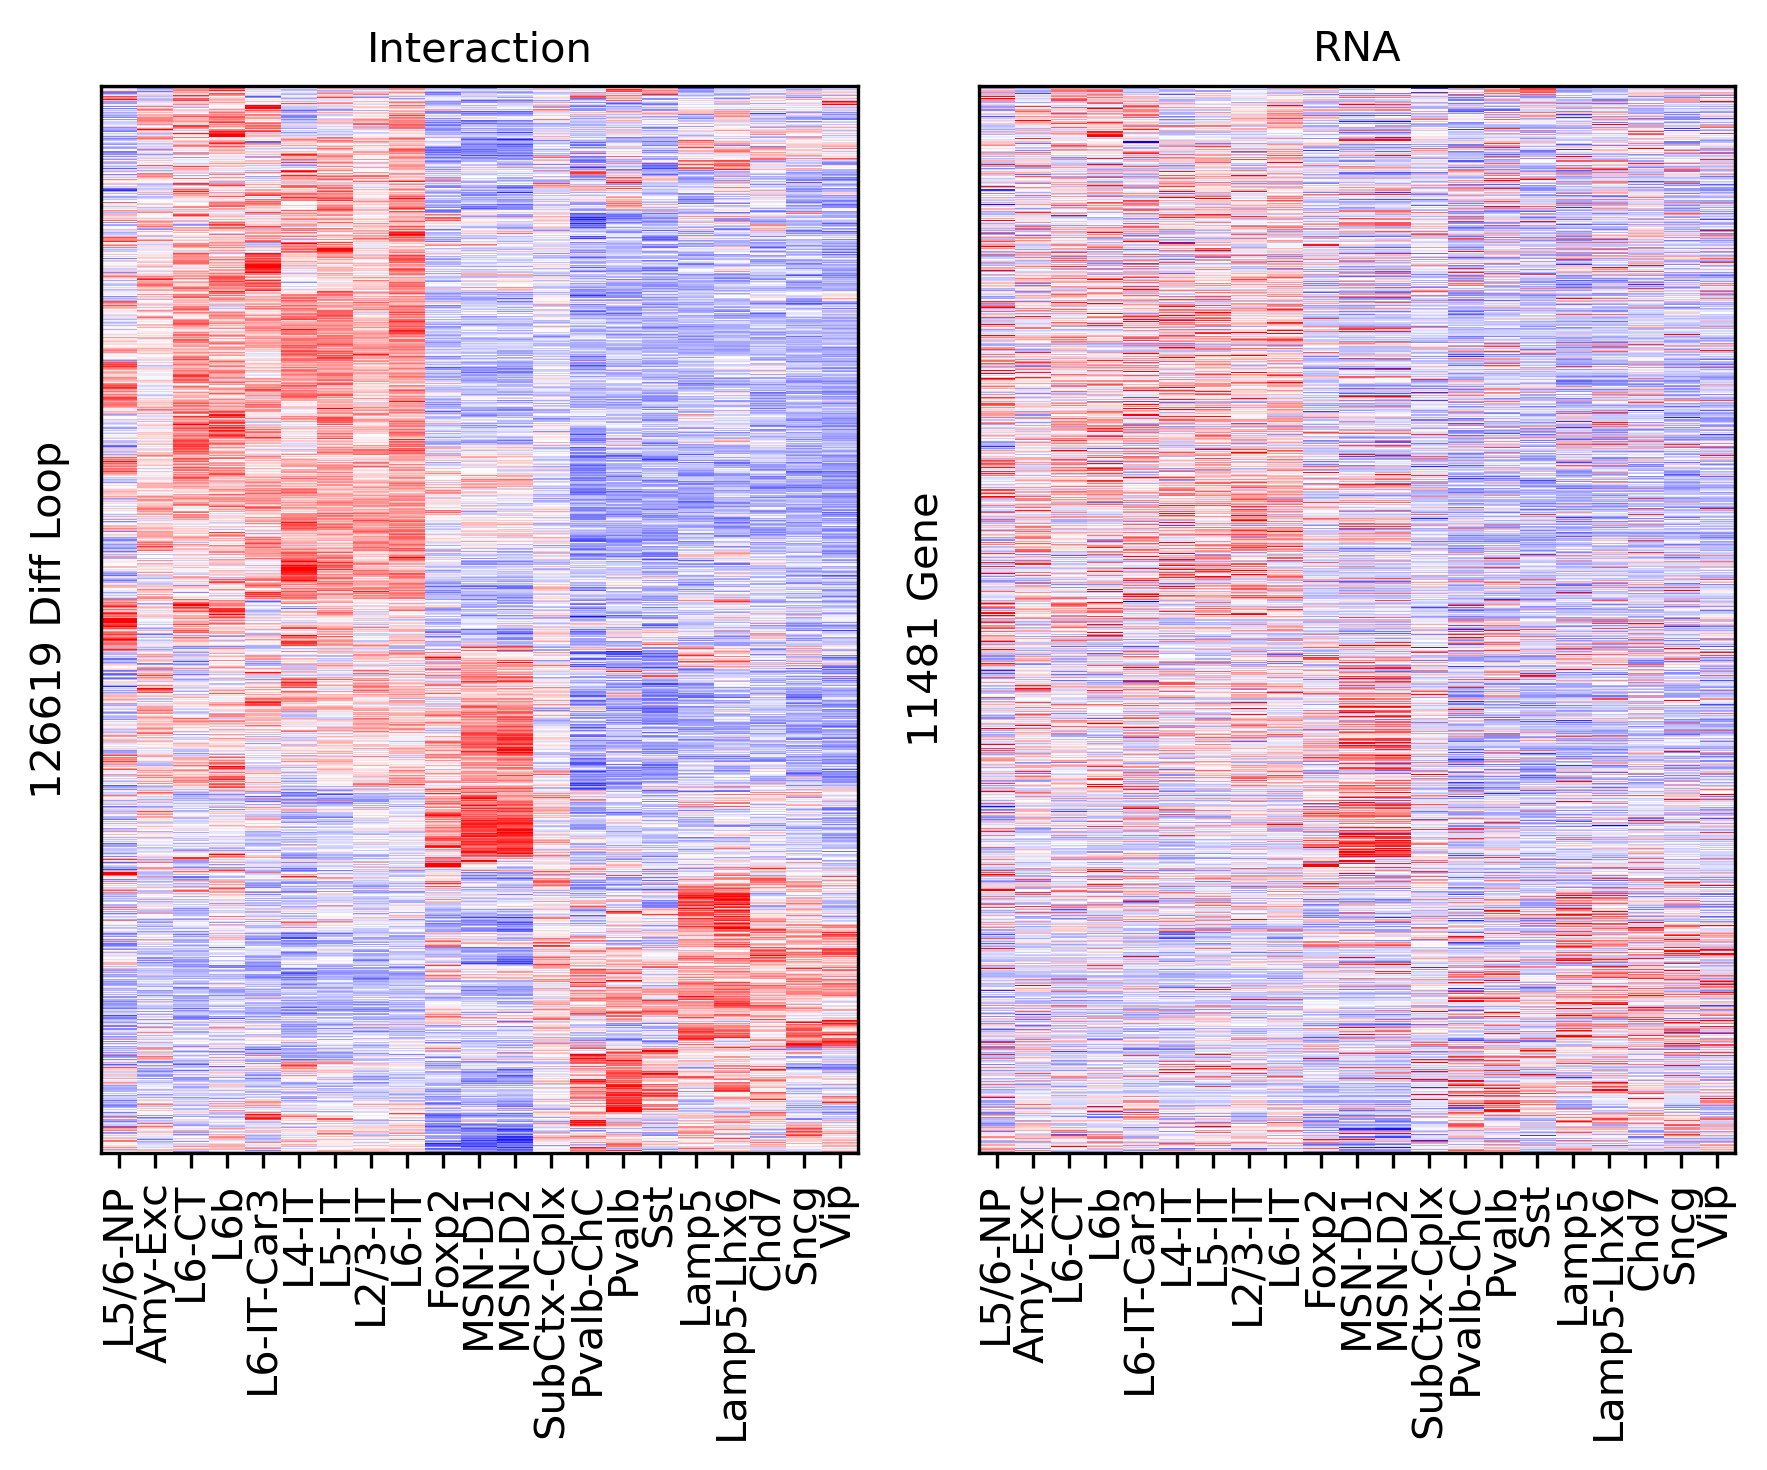

In [94]:
fig, axes = plt.subplots(1, 2, sharey='all', figsize=(6,5), dpi=300)

ax = axes[0]
ax.imshow(tmp3c[np.ix_(sel[rorder], corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('Interaction', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)
ax.set_yticks([])
ax.set_ylabel(f'{np.unique(selloop).shape[0]} Diff Loop')

ax = axes[1]
ax.imshow(tmprna[np.ix_(sel[rorder], corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('RNA', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)
ax.set_ylabel(f'{np.unique(selgene).shape[0]} Gene')

plt.tight_layout()
# plt.savefig(f'majortype_{group_name}_diffloop_3C_RNA_allbody.pdf', transparent=True)


In [95]:
corr = np.array([pearsonr(xx, yy)[0] for xx,yy in zip(tmp3c, tmprna)])
corr_all.append(corr)


## Differential Loop vs DEG body

In [96]:
selp = pd.Index(selgene).isin(genefilter.index[deg==1])

In [97]:
selgene = selgene[selp]
selloop = selloop[selp]

In [98]:
tmp3c = tmp3c[selp]
tmprna = tmprna[selp]

In [99]:
np.random.seed(0)
sel = np.random.choice(np.arange(len(tmp3c)), 2000, False)


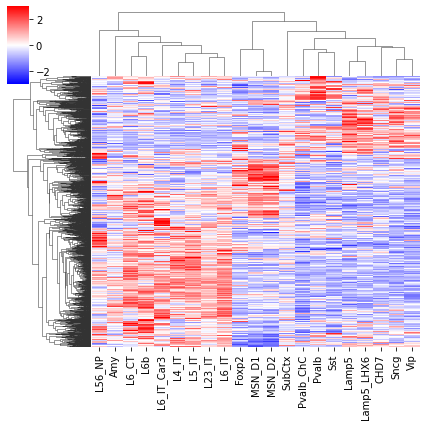

In [100]:
cg = sns.clustermap(tmp3c[sel], cmap='bwr', vmin=-3, vmax=3, metric='cosine', xticklabels=leg, yticklabels=[], figsize=(6,6))


In [101]:
rorder = cg.dendrogram_row.reordered_ind.copy()
corder = cg.dendrogram_col.reordered_ind.copy()

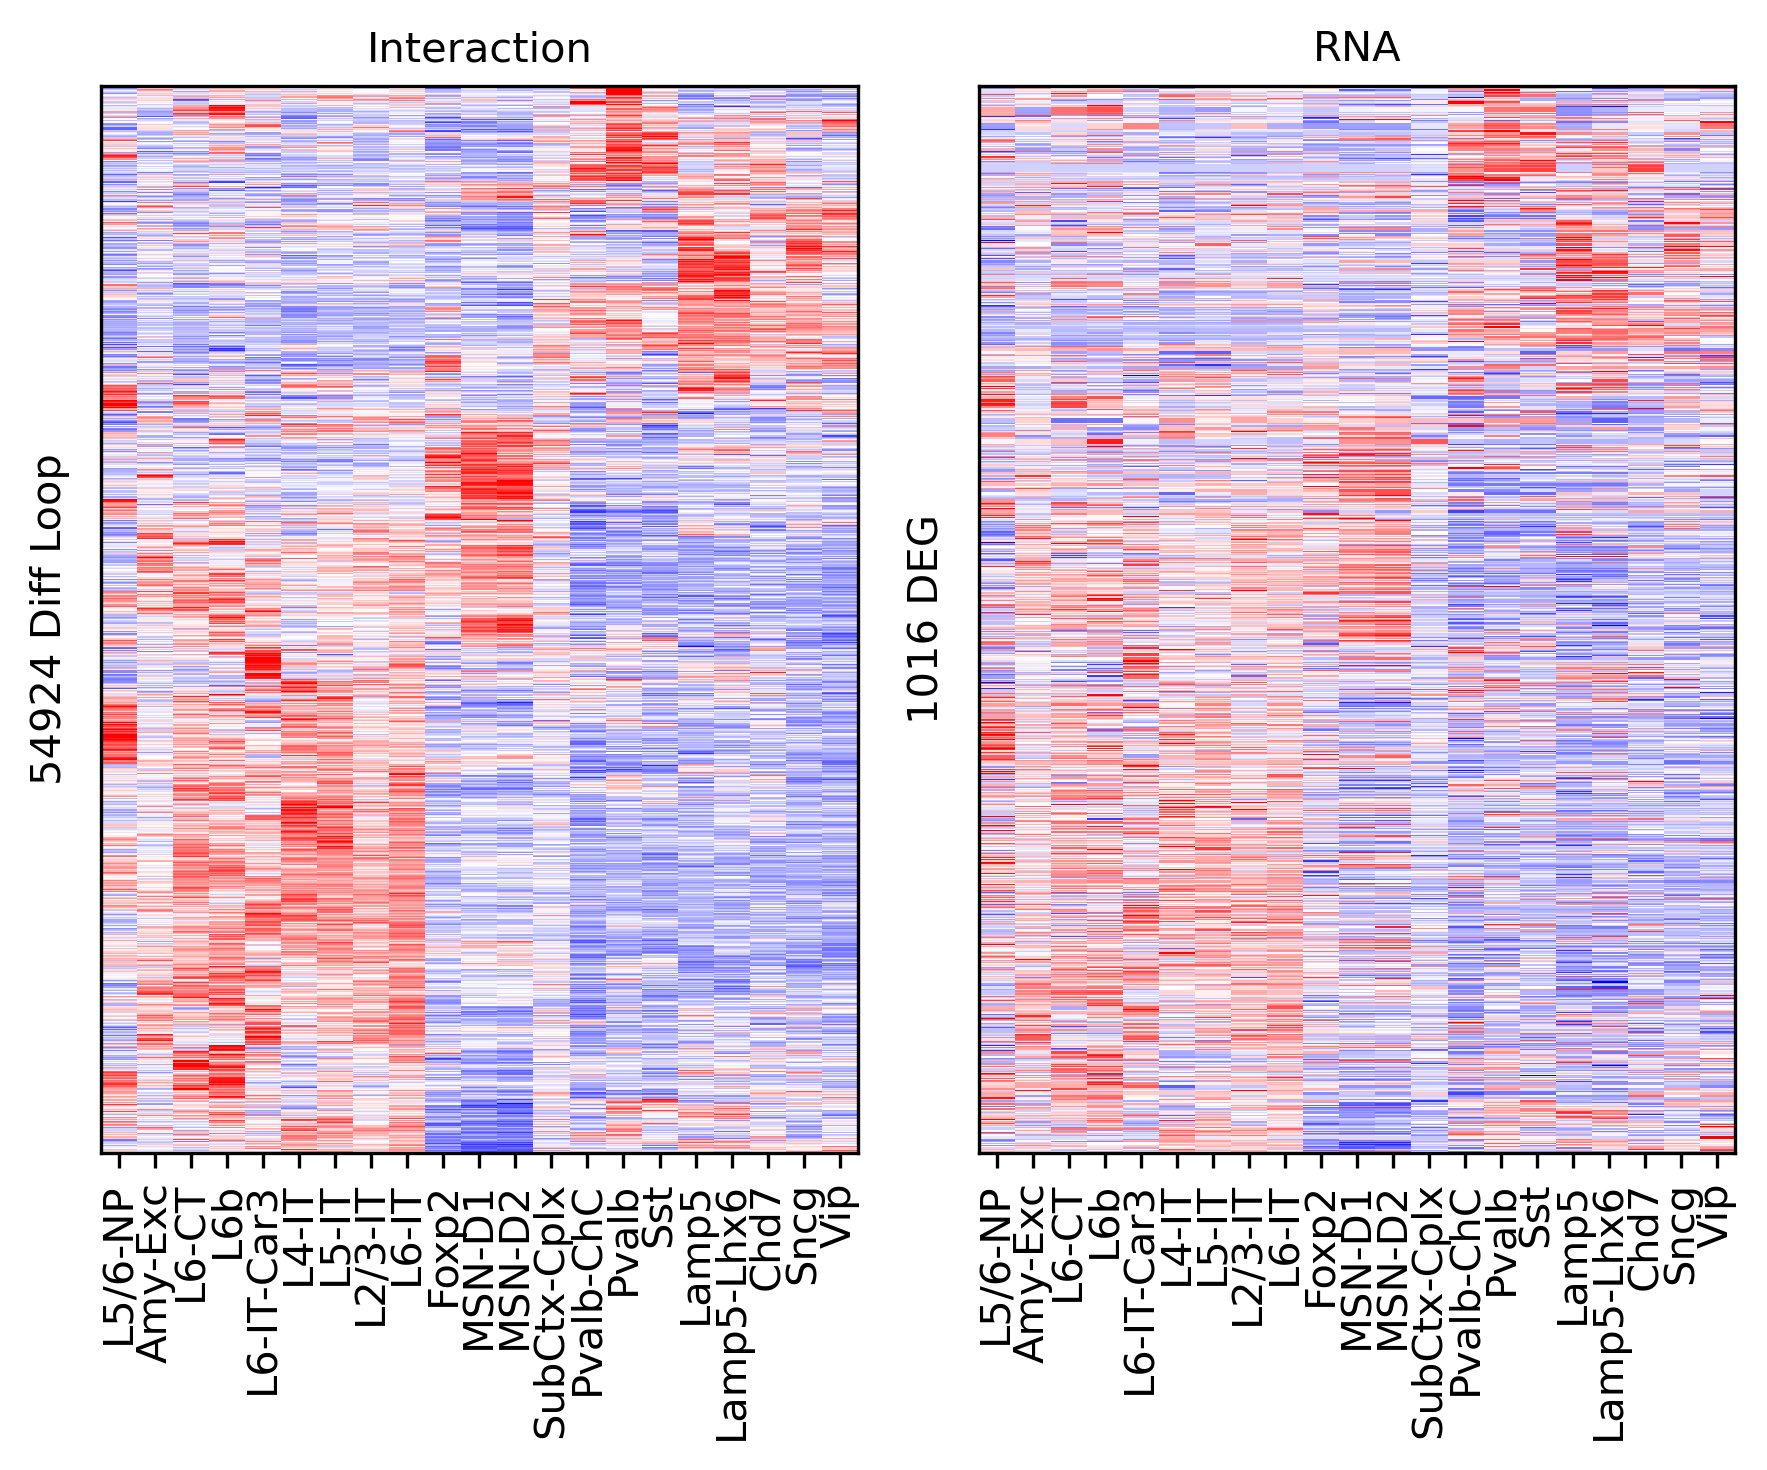

In [102]:
fig, axes = plt.subplots(1, 2, sharey='all', figsize=(6,5), dpi=300)

ax = axes[0]
ax.imshow(tmp3c[np.ix_(sel[rorder], corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('Interaction', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)
ax.set_yticks([])
ax.set_ylabel(f'{np.unique(selloop).shape[0]} Diff Loop')

ax = axes[1]
ax.imshow(tmprna[np.ix_(sel[rorder], corder)], cmap='bwr', aspect='auto', vmin=-3, vmax=3, interpolation='none')
ax.set_title('RNA', fontsize=10)
# sns.despine(ax=ax, left=True, bottom=True)
ax.set_xticks(np.arange(len(leg)))
ax.set_xticklabels(legname[corder], rotation=90)
ax.set_ylabel(f'{np.unique(selgene).shape[0]} DEG')

plt.tight_layout()
# plt.savefig(f'majortype_{group_name}_diffloop_3C_RNA_degbody.pdf', transparent=True)


In [103]:
corr = np.array([pearsonr(xx, yy)[0] for xx,yy in zip(tmp3c, tmprna)])
corr_all.append(corr)


In [104]:
np.save(f'{outdir}corr_diffloop_rna.npy', corr_all)

In [105]:
corr_all = np.load(f'{outdir}corr_diffloop_rna.npy', allow_pickle=True)[[0,2,4,1,3,5]]

Text(0, 0.5, 'PCC with Interaction')

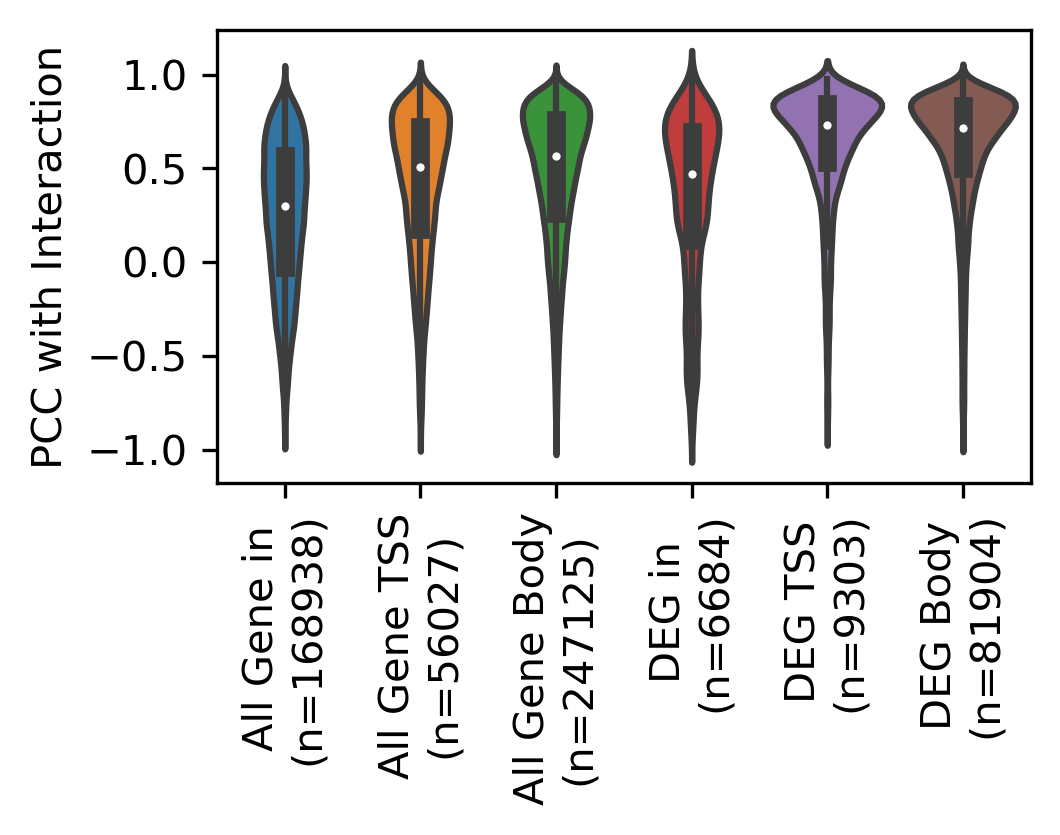

In [106]:
xleg = [f'{xx}\n(n={yy.shape[0]})' for xx,yy in zip(['All Gene in', 'All Gene TSS', 'All Gene Body', 'DEG in', 'DEG TSS', 'DEG Body'], corr_all)]
fig, ax = plt.subplots(figsize=(3.5,2), dpi=300)
sns.violinplot(corr_all, ax=ax)
ax.set_xticklabels(xleg, rotation=90, ha='center')
ax.set_ylabel('PCC with Interaction')
# plt.tight_layout()
# plt.savefig(f'majortype_{group_name}_diffloop_rnacorr.pdf', transparent=True)


In [107]:
[[xx.shape, np.median(xx)] for xx in corr_all]

[[(168938,), 0.2998781555063824],
 [(56027,), 0.505946906771439],
 [(247125,), 0.5644447754352515],
 [(6684,), 0.467422834052747],
 [(9303,), 0.733468155919242],
 [(81904,), 0.7141026887446646]]